Simulaciones de base para comparación con métodos de redes neuronales en la predicción de precio de criptomonedas.

Se harán 4 predicciones por cada método, correspondientes al día a predecir. Entonces, una predicción "_1" indica que se tomaron todos los datos anteriores como input para predecir el día siguiente, mientras que una predicción "_5" indica que los datos de input se usan para predecir el día 5 posterior al conjunto de datos. 
Notar que "_5" predice UN día, NO los días [1,2,3,4,5] después del conjunto de input.

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Keras
from math import sqrt
from sklearn.metrics import mean_squared_error

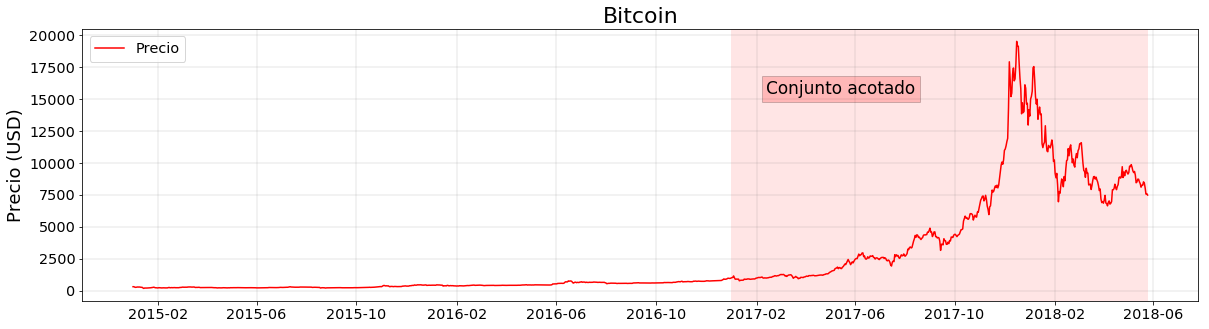

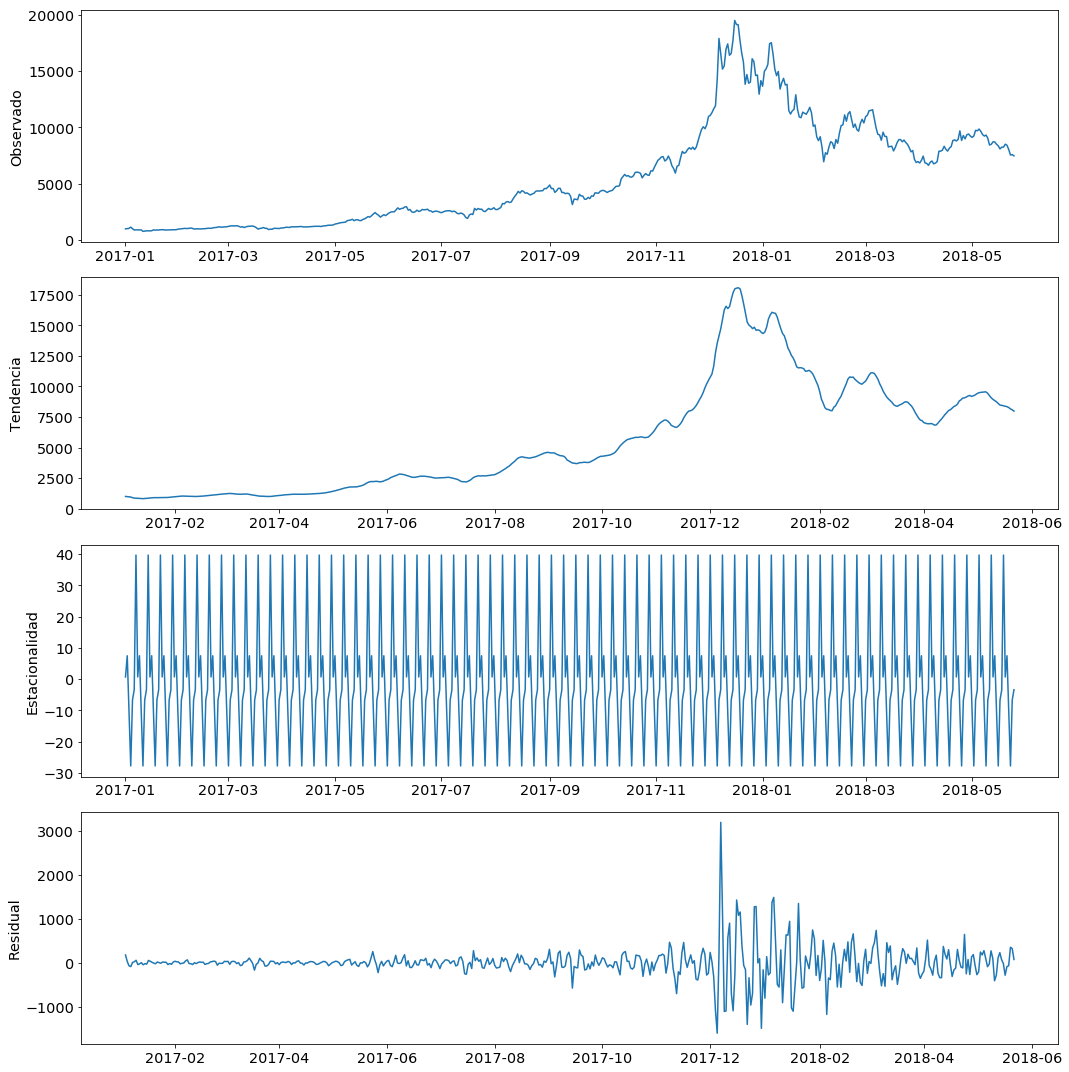

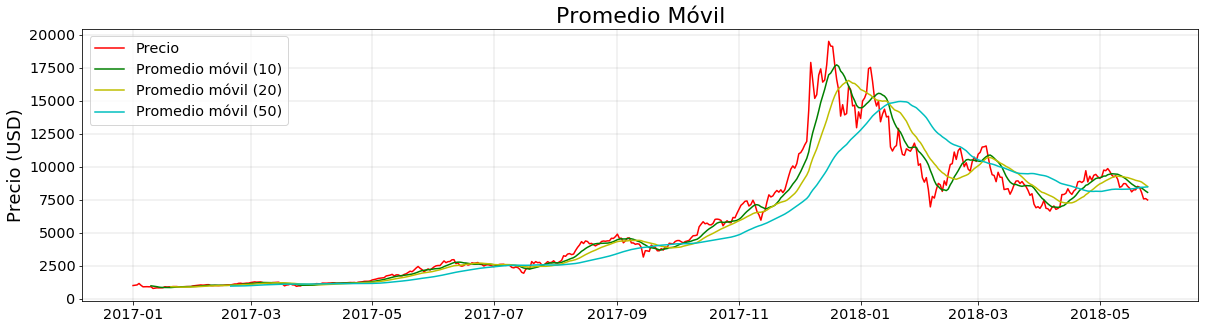

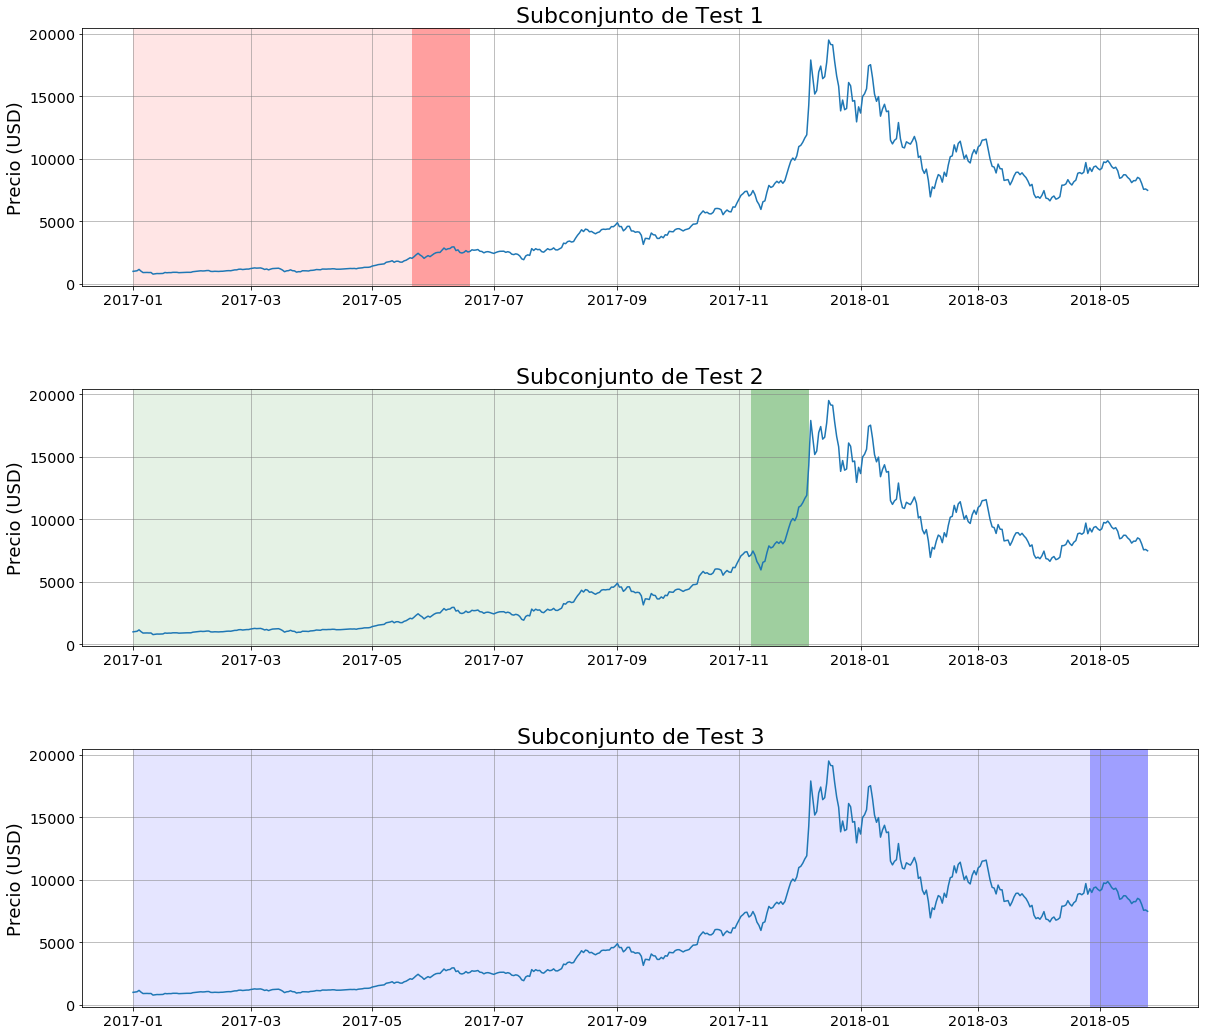

In [3]:
data = pd.read_csv('data/data.csv', usecols=['Date','Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

#Simulaciones
test_size = 30
futuro = [1,2,3]
moneda = 'bitcoin'
target = 'Close bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores_test = ['r','g','b','c']
colores_futuro = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# Visualización de la serie completa
fig = plt.figure(figsize=(20,5))
plt.plot(data, color = 'r', label="Precio")
plt.axvspan('2017-01-01', data.index[-1], facecolor='r', alpha=0.1)
fig.text(0.6, 0.7, 'Conjunto acotado', fontsize=17, bbox=dict(facecolor='red', alpha=0.2))
plt.ylabel('Precio (USD)', fontsize=18)
plt.legend(loc='upper left')
plt.title("Bitcoin",fontsize=22)
plt.grid(color='grey', linestyle='-', linewidth=0.2)

# Se acota el conjunto de datos para un período significativo
data = data['2017-01-01':]

# Descomposición de la serie en componentes 
res = sm.tsa.seasonal_decompose(data,model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,15))
axes[0].plot(res.observed);axes[0].set_ylabel('Observado')
axes[1].plot(res.trend);axes[1].set_ylabel('Tendencia')
axes[2].plot(res.seasonal);axes[2].set_ylabel('Estacionalidad')
axes[3].plot(res.resid);axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

# Visualización del promedio móvil para 10, 20 y 50 días
promedio_movil_10 = data.rolling(window=10).mean()
promedio_movil_20 = data.rolling(window=20).mean()
promedio_movil_50 = data.rolling(window=50).mean()
fig = plt.figure(figsize=(20,5))
plt.plot(data, color = 'r', label="Precio")
plt.plot(promedio_movil_10, color='g', label="Promedio móvil (10)")
plt.plot(promedio_movil_20, color='y', label="Promedio móvil (20)")
plt.plot(promedio_movil_50, color='c', label="Promedio móvil (50)")
plt.ylabel('Precio (USD)', fontsize=18)
plt.legend(loc='upper left')
plt.title("Promedio Móvil",fontsize=22)
plt.grid(color='grey', linestyle='-', linewidth=0.2)

# Visualización de separación en tres tests
fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.4)
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    start_test = end-test_size
    subprediccion = data[0:end]
    subprediccion_test = data[start_test:end]    
    ax = plt.subplot(gs[n_test, 0:])
    ax.plot(data.index, data)  
    plt.axvspan(subprediccion.index[0], subprediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)
    plt.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.3)
    plt.ylabel('Precio (USD)', fontsize=18)
    #plt.legend(loc='upper left', labels=data.columns)
    plt.title("Subconjunto de Test " + str(n_test+1),fontsize=22)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)

In [4]:
#Método para graficar las predicciones
def graficarBaselines(predicciones,nombre):
    fig = plt.figure(figsize=(25,10*4))
    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

    # Graficar la predicción completa (todos los subconjuntos de test)
    axPrediccionCompleta = plt.subplot(gs[0, 0:])
    axPrediccionCompleta.plot(predicciones.index, predicciones[predicciones.columns[0]], color='dimgray', label="Precio Real")  
    axPrediccionCompleta.set_xlabel('Fecha', fontsize=18)
    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
    plt.xticks(rotation=30, ha="right")
    axPrediccionCompleta.set_title("Predicciones - Método " + nombre, fontsize=22)
    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
    col=0
    for c in predicciones.columns[1:]:
        #Graficar cada prediccion
        axPrediccionCompleta.plot(predicciones.index, predicciones[c], label=c, color=colores_futuro[col])   
        col+=1
    axPrediccionCompleta.legend(loc='upper left')  

    # Graficar cada subconjunto de test
    i=1 #index de subplot
    rmses_y = []
    rmses_x = []
    prediccionxdataset = pd.DataFrame() # Dataframe con los tres tests, sin NaN
    for n_test in range(0,N_tests): 
        end = int((n_test+1)*len(predicciones)/N_tests)
        subprediccion = predicciones[0:end]
        subprediccion_test = subprediccion[-test_size:]
        prediccionxdataset = prediccionxdataset.append(subprediccion_test)
        
        #Colorear cada porcion de testing
        axPrediccionCompleta.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)  

        #Cada prediccion   
        axPrediccion = plt.subplot(gs[i, 1:])
        axPrediccion.plot(subprediccion[subprediccion.columns[0]].index[-45:], subprediccion[subprediccion.columns[0]][-45:], color='dimgray', label="Precio Real")
        axPrediccion.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)
        axPrediccion.set_xlabel('Fecha', fontsize=18)
        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
        plt.xticks(rotation=30, ha="right")
        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5) 

        rmses_y_subprediccion = []
        rmses_x_subprediccion = []
        col=0 #color de futuro
        for c in subprediccion_test.columns[1:]:
            axPrediccion.plot(subprediccion_test[c].index, subprediccion_test[c], label=c, color=colores_futuro[col]);col+=1

            rmse = sqrt(mean_squared_error(subprediccion_test[subprediccion_test.columns[0]], 
                                           subprediccion_test[c]))
            rmses_y_subprediccion.append(rmse)        
            rmses_y.append(rmse)
            rmses_x.append(c +'('+ str(i) +')')  
            rmses_x_subprediccion.append(c +'('+ str(i) +')')  

        axPrediccion.legend(loc='upper left')

        #RMSE
        width = 1/1.5
        barplot = plt.subplot(gs[i, 0])
        barplot = plt.bar(rmses_x_subprediccion, rmses_y_subprediccion, width)
        col = 0
        for rect in barplot: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
            rect.set_color(colores_futuro[col]); col+=1
        plt.xticks(rotation=30, ha="right")
        plt.title("RMSE por día futuro", fontsize=22)

        i+=1
            
    #Graficar todos los RMSE
    width = 1/1.5
    barplot = plt.subplot(gs[i, 0:3 ])
    bars = plt.bar(rmses_x, rmses_y, width)
    for n_test in range(0,N_tests):
        col = 0;
        for rect in bars[n_test*len(predicciones.columns[1:]) : (n_test+1)*len(predicciones.columns[1:])]: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
            rect.set_color(colores_futuro[col]); col+=1
            barplot.axvspan(rect.get_x(),rect.get_x()+rect.get_width(),facecolor=colores_test[n_test], alpha=0.1)
    plt.xticks(rotation=20,ha='right')
    plt.title("RMSE "+ nombre,fontsize=20)
    
    rmses_f_y = []; rmses_f_x = []
    for c in prediccionxdataset.columns[1:]:
        rmse_futuro = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                               prediccionxdataset[c]))
        rmses_f_y.append(rmse_futuro)
        rmses_f_x.append(c)
    #Graficar RMSE por dia futuro
    width = 1/1.5
    barplot = plt.subplot(gs[i, 3: ])
    bars = plt.bar(rmses_f_x, rmses_f_y, width)
    for n_test in range(0,N_tests):
        col = 0;
        for rect in bars: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=18, ha='center',va='bottom')
            rect.set_color(colores_futuro[col]); col+=1
    plt.xticks(rotation=20,ha='right')
    plt.title("RMSE por día futuro",fontsize=20)

    plt.savefig("baselines/"+ nombre +".png", bbox_inches='tight')

Método "Suavizamiento Exponencial Simple": cada observación utilizada en el promedio tiene un peso asociado que decrementa exponencialmente a medida que se aleja en el tiempo (las observaciones más viejas tienen los pesos más pequeños). Modificando el factor "alfa" en la fórmula se ajusta el promedio y el error en la prediccion.

Primero, se hace el método utilizando conjunto de entrenamiento fijo y haciendo una predicción de 30 días.

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

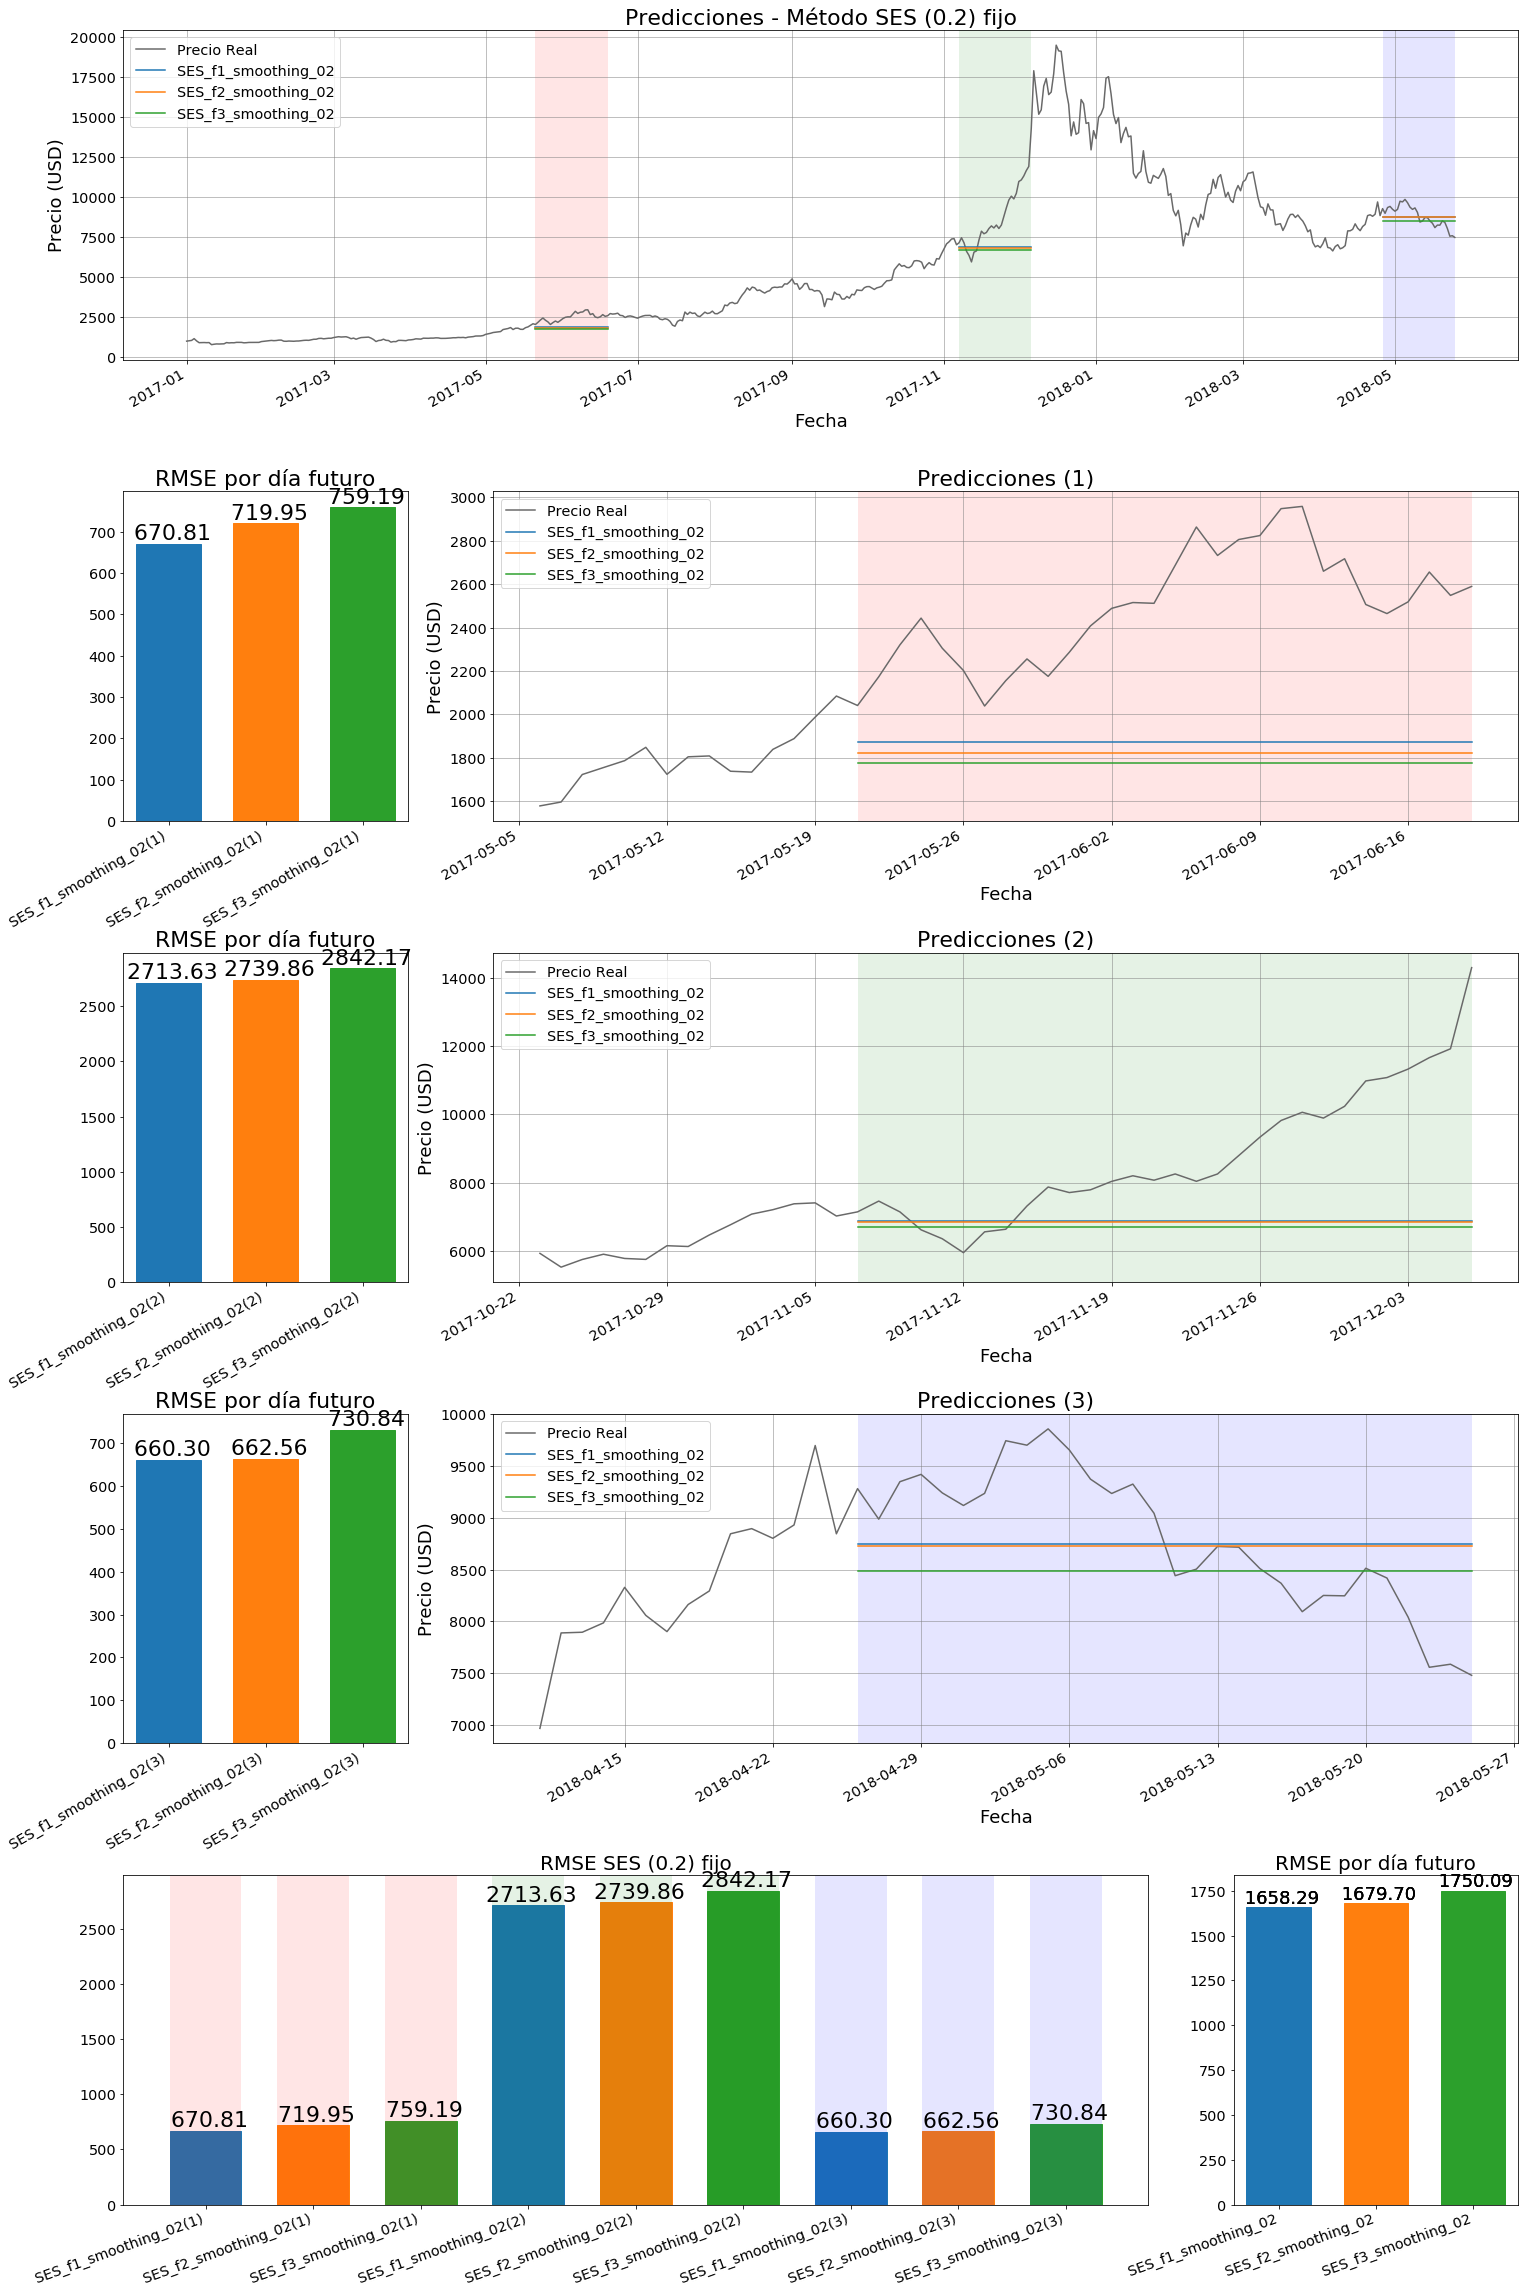

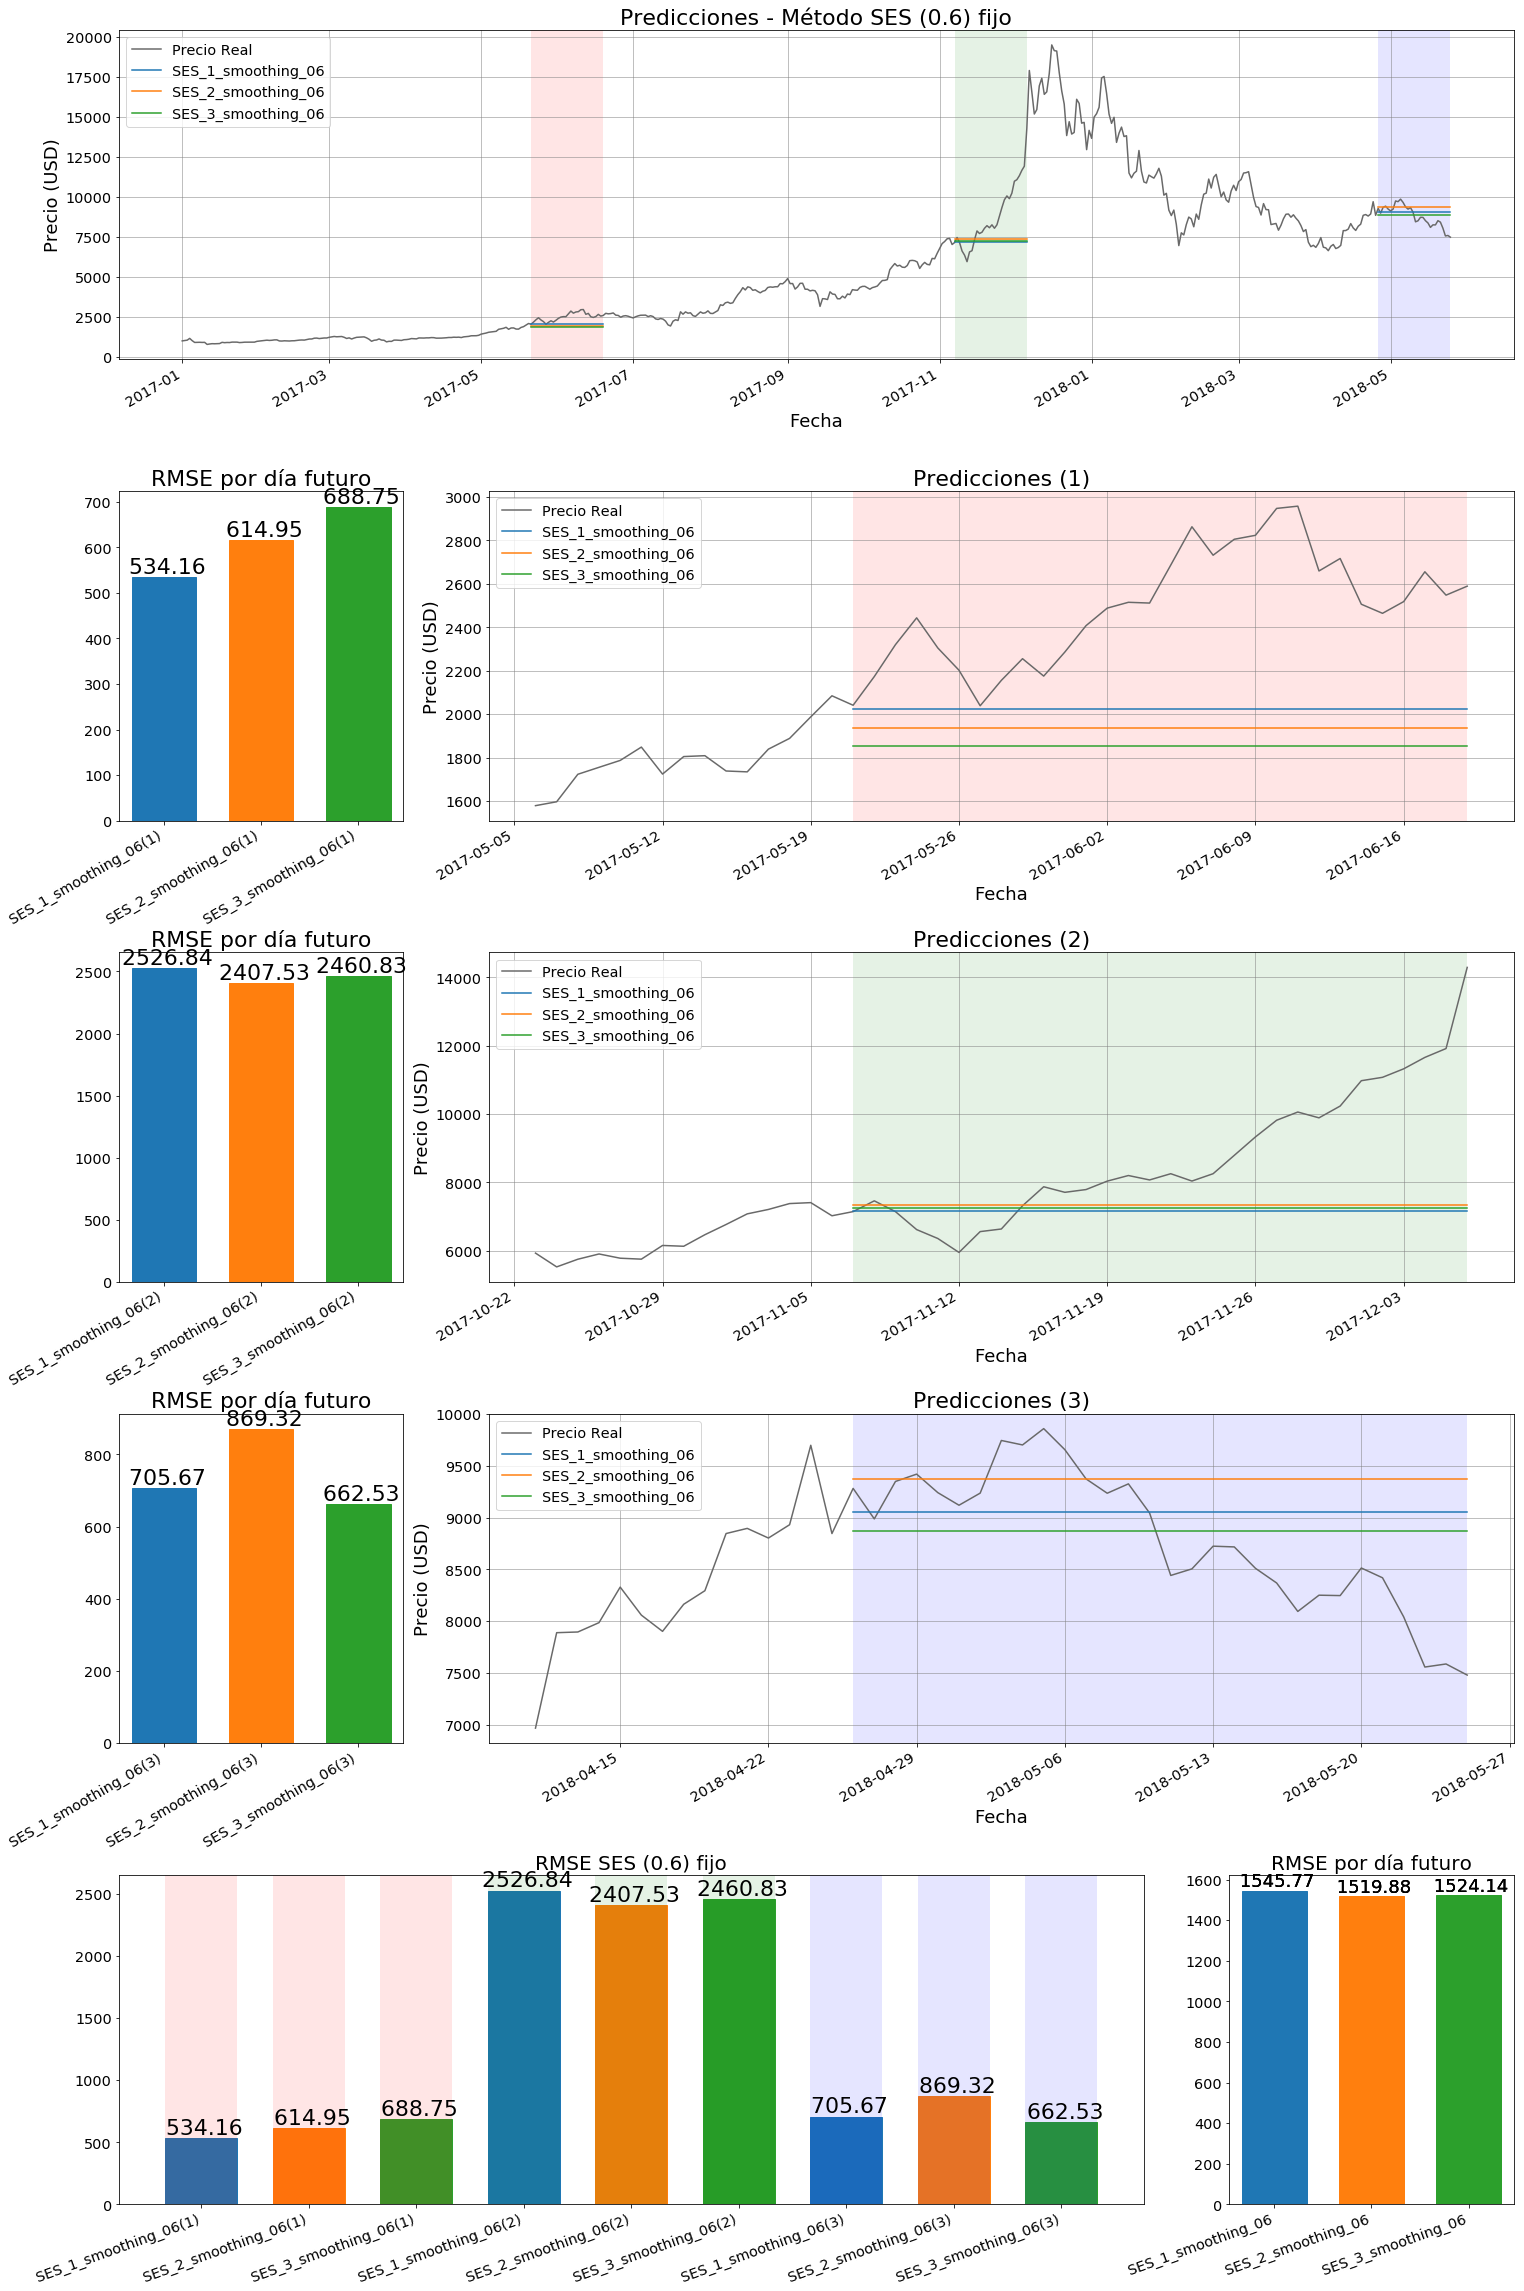

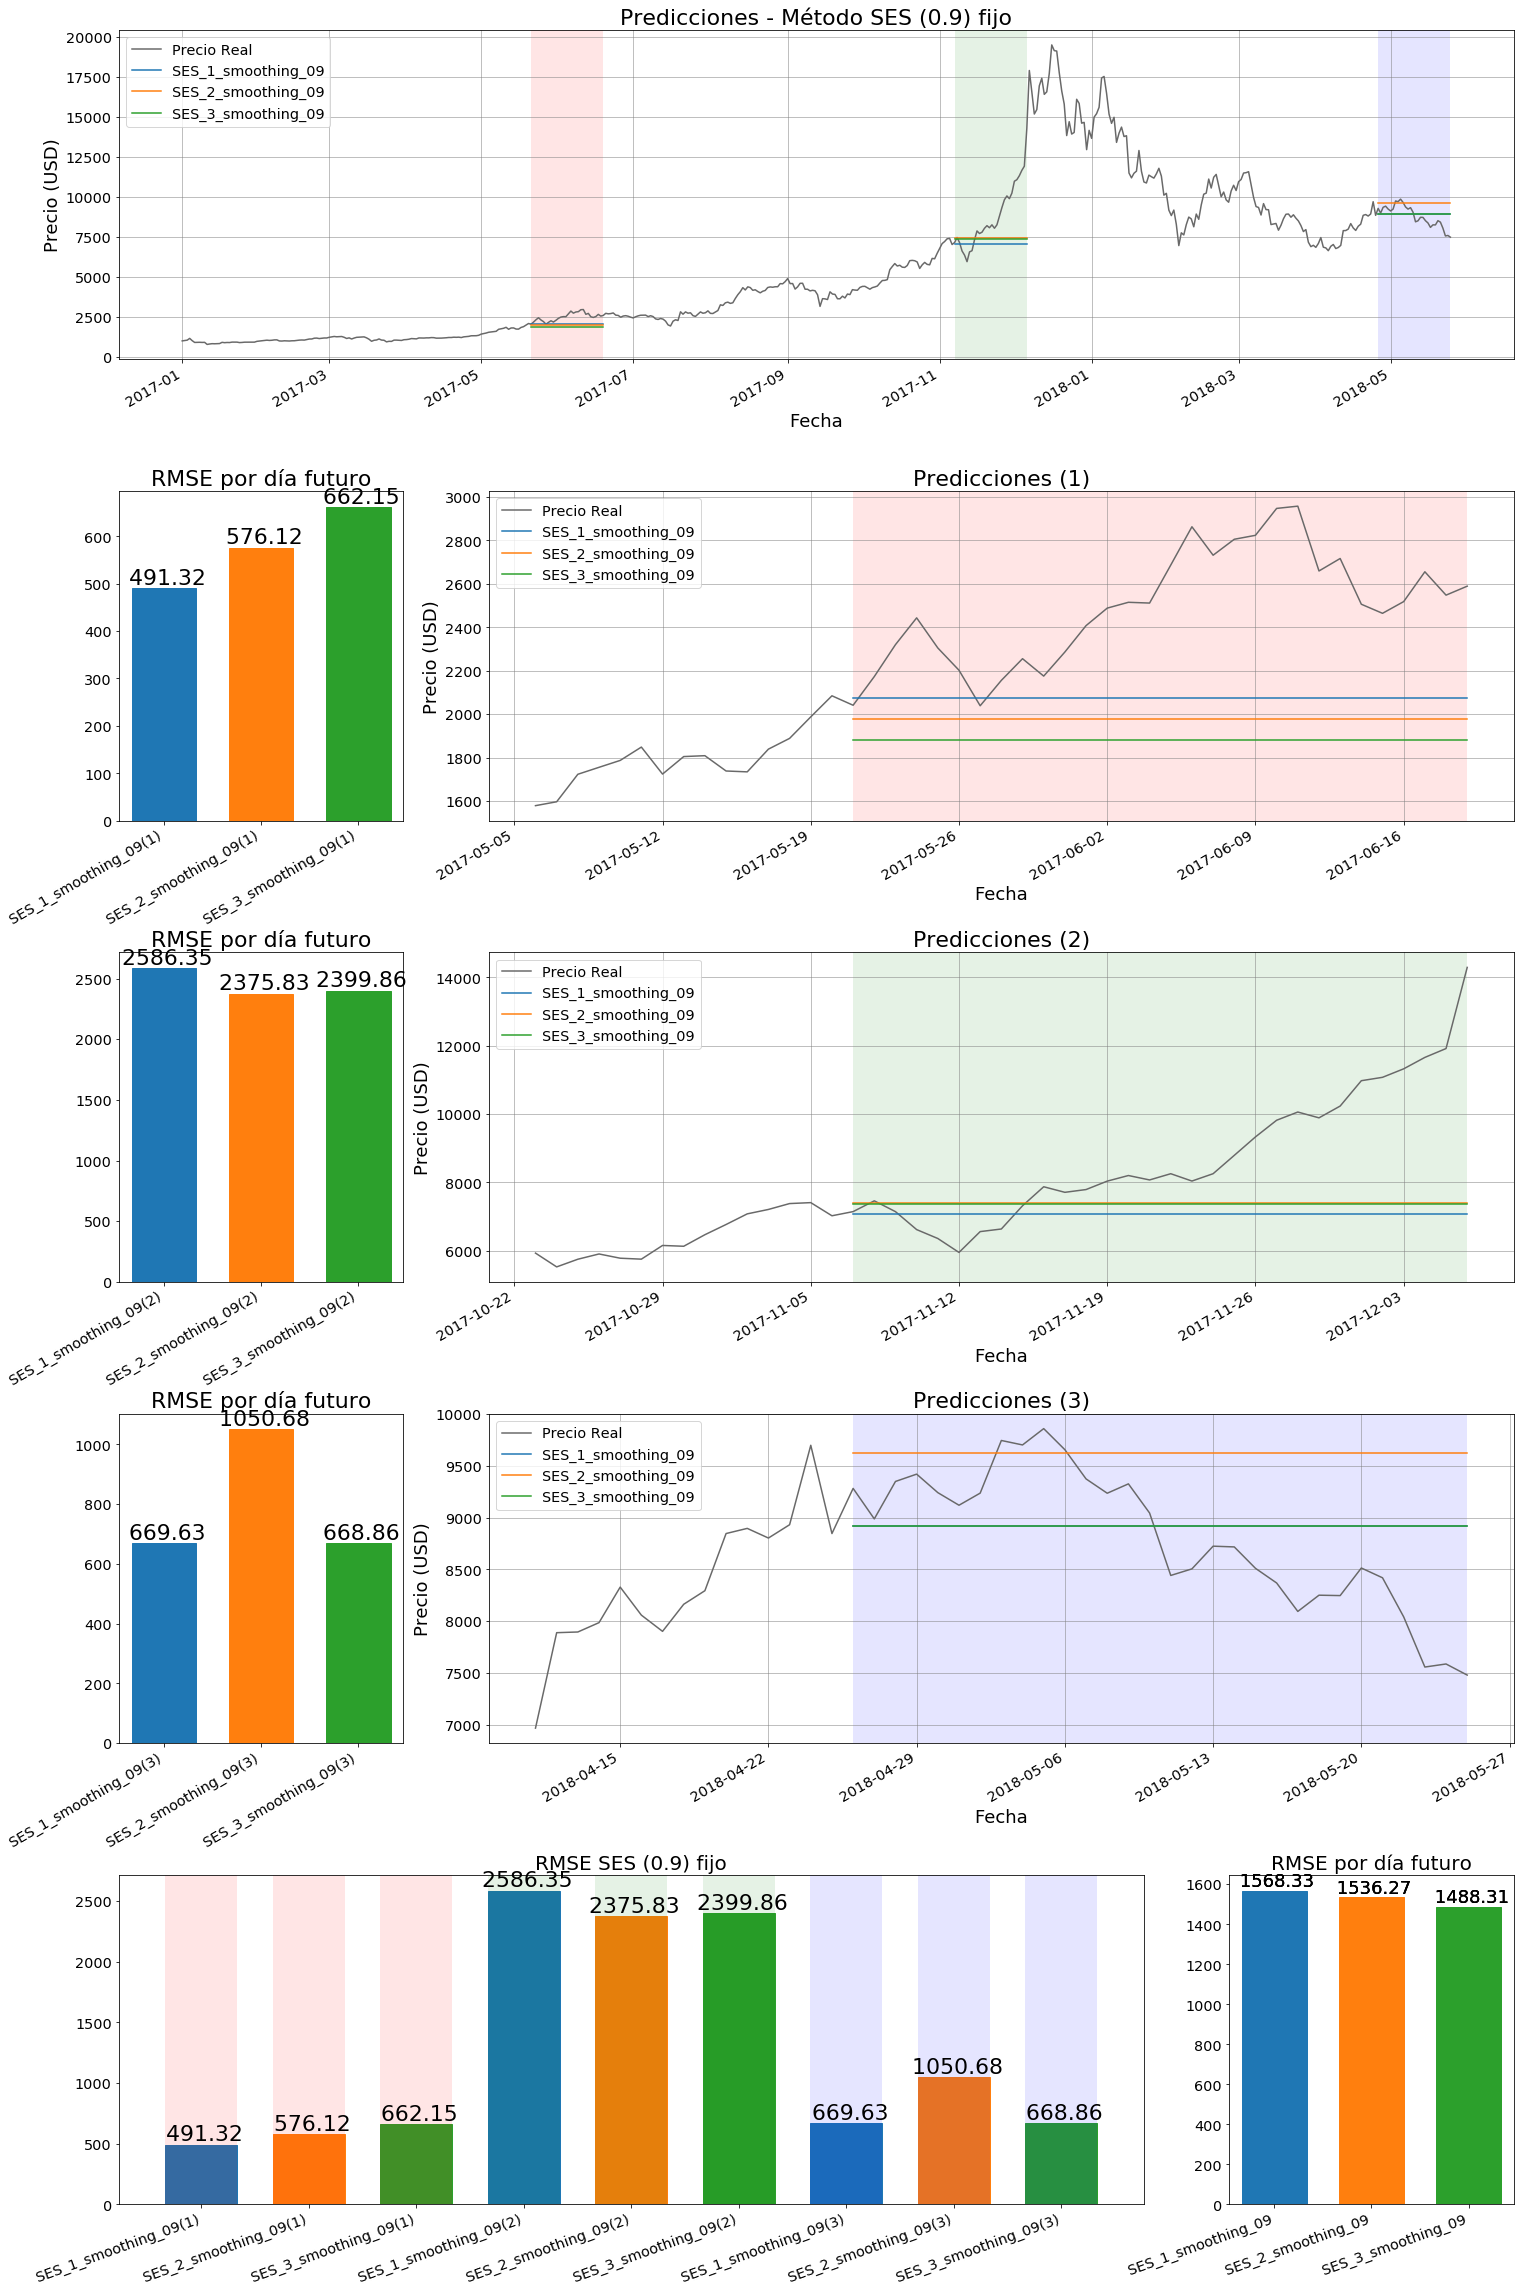

In [5]:
# Simple Exponential Smoothing 0.2
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_f' + str(f) + "_smoothing_02"] = np.nan
        training = dataset[0:-test_size-f+1]
        ses02 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.2,optimized=False)
        test['SES_f' + str(f) + "_smoothing_02"] = ses02.forecast(test_size)
            
    predicciones = predicciones.append(test)
                
predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_02_fijo.csv')

graficarBaselines(predicciones,"SES (0.2) fijo")

# Simple Exponential Smoothing 0.6
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_' + str(f) + "_smoothing_06"] = np.nan  
        training = dataset[0:-test_size-f+1]
        ses06 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.6,optimized=False)
        test['SES_' + str(f) + "_smoothing_06"] = ses06.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_06_fijo.csv')

graficarBaselines(predicciones,"SES (0.6) fijo")

# Simple Exponential Smoothing 0.9
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_' + str(f) + "_smoothing_09"] = np.nan
        training = dataset[0:-test_size-f+1]
        ses09 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.9,optimized=False)
        test['SES_' + str(f) + "_smoothing_09"] = ses09.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_09_fijo.csv')

graficarBaselines(predicciones,"SES (0.9) fijo")

Método SES pero con conjunto de entrenamiento rolling (se re-entrena el método por cada día que pasa, y se hace una predicción única por cada día)

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

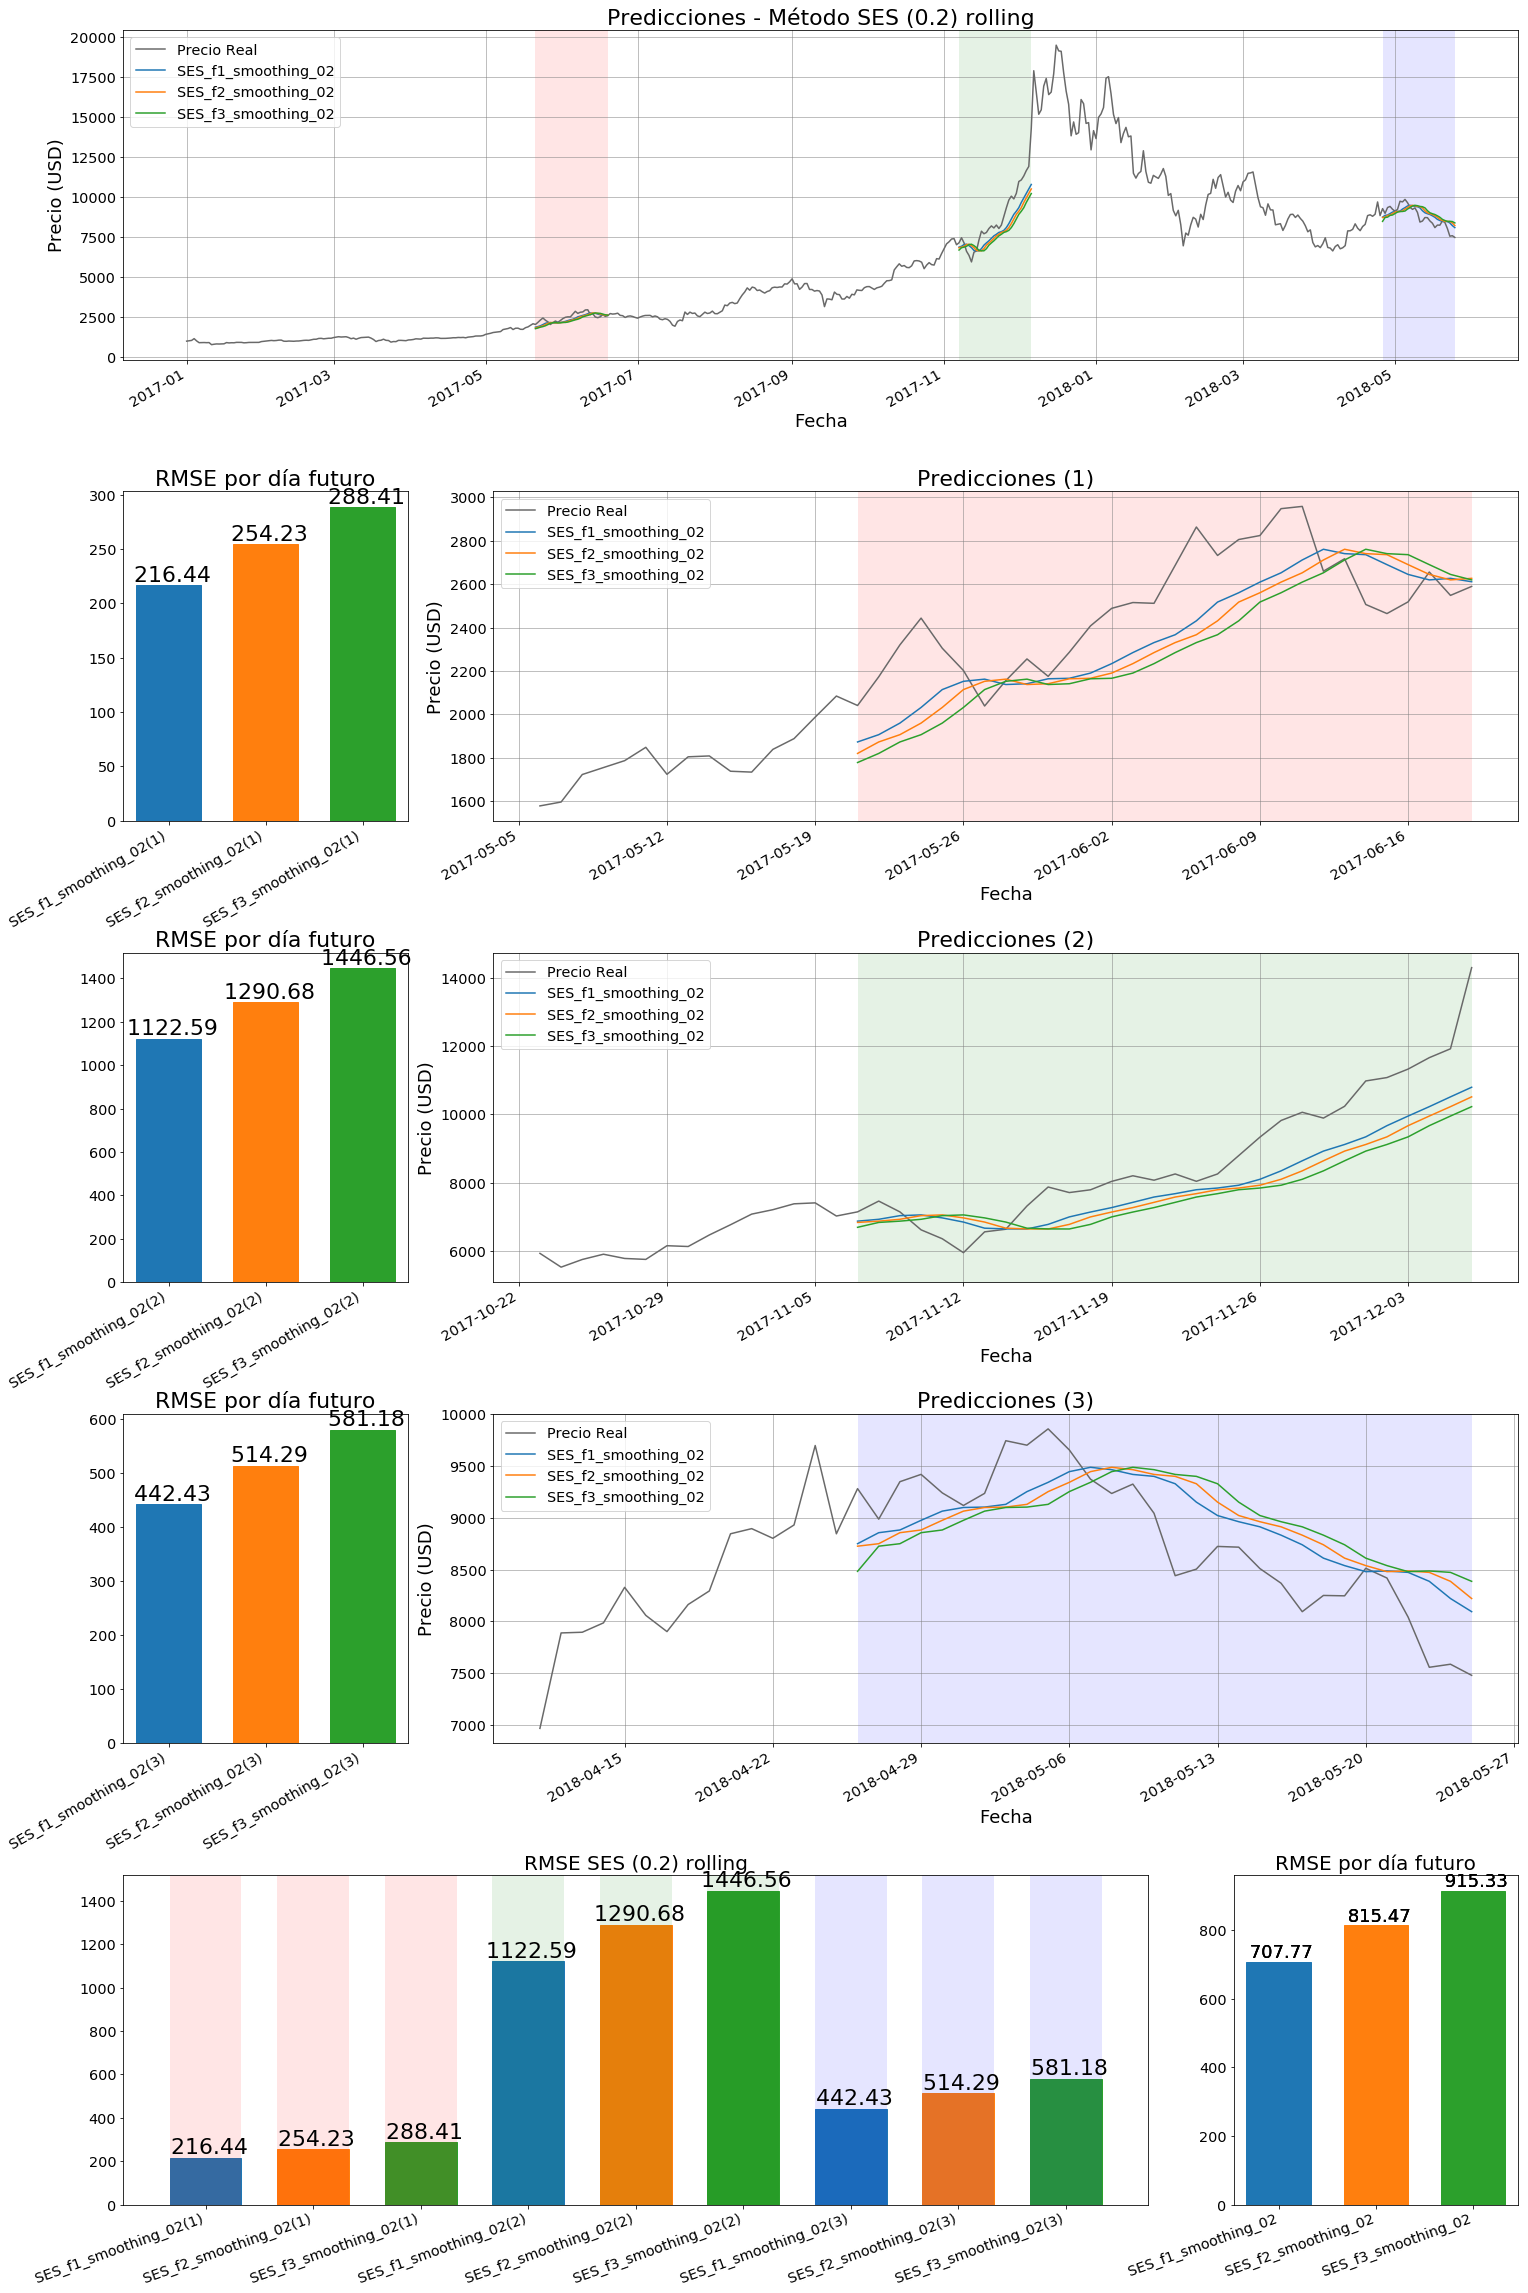

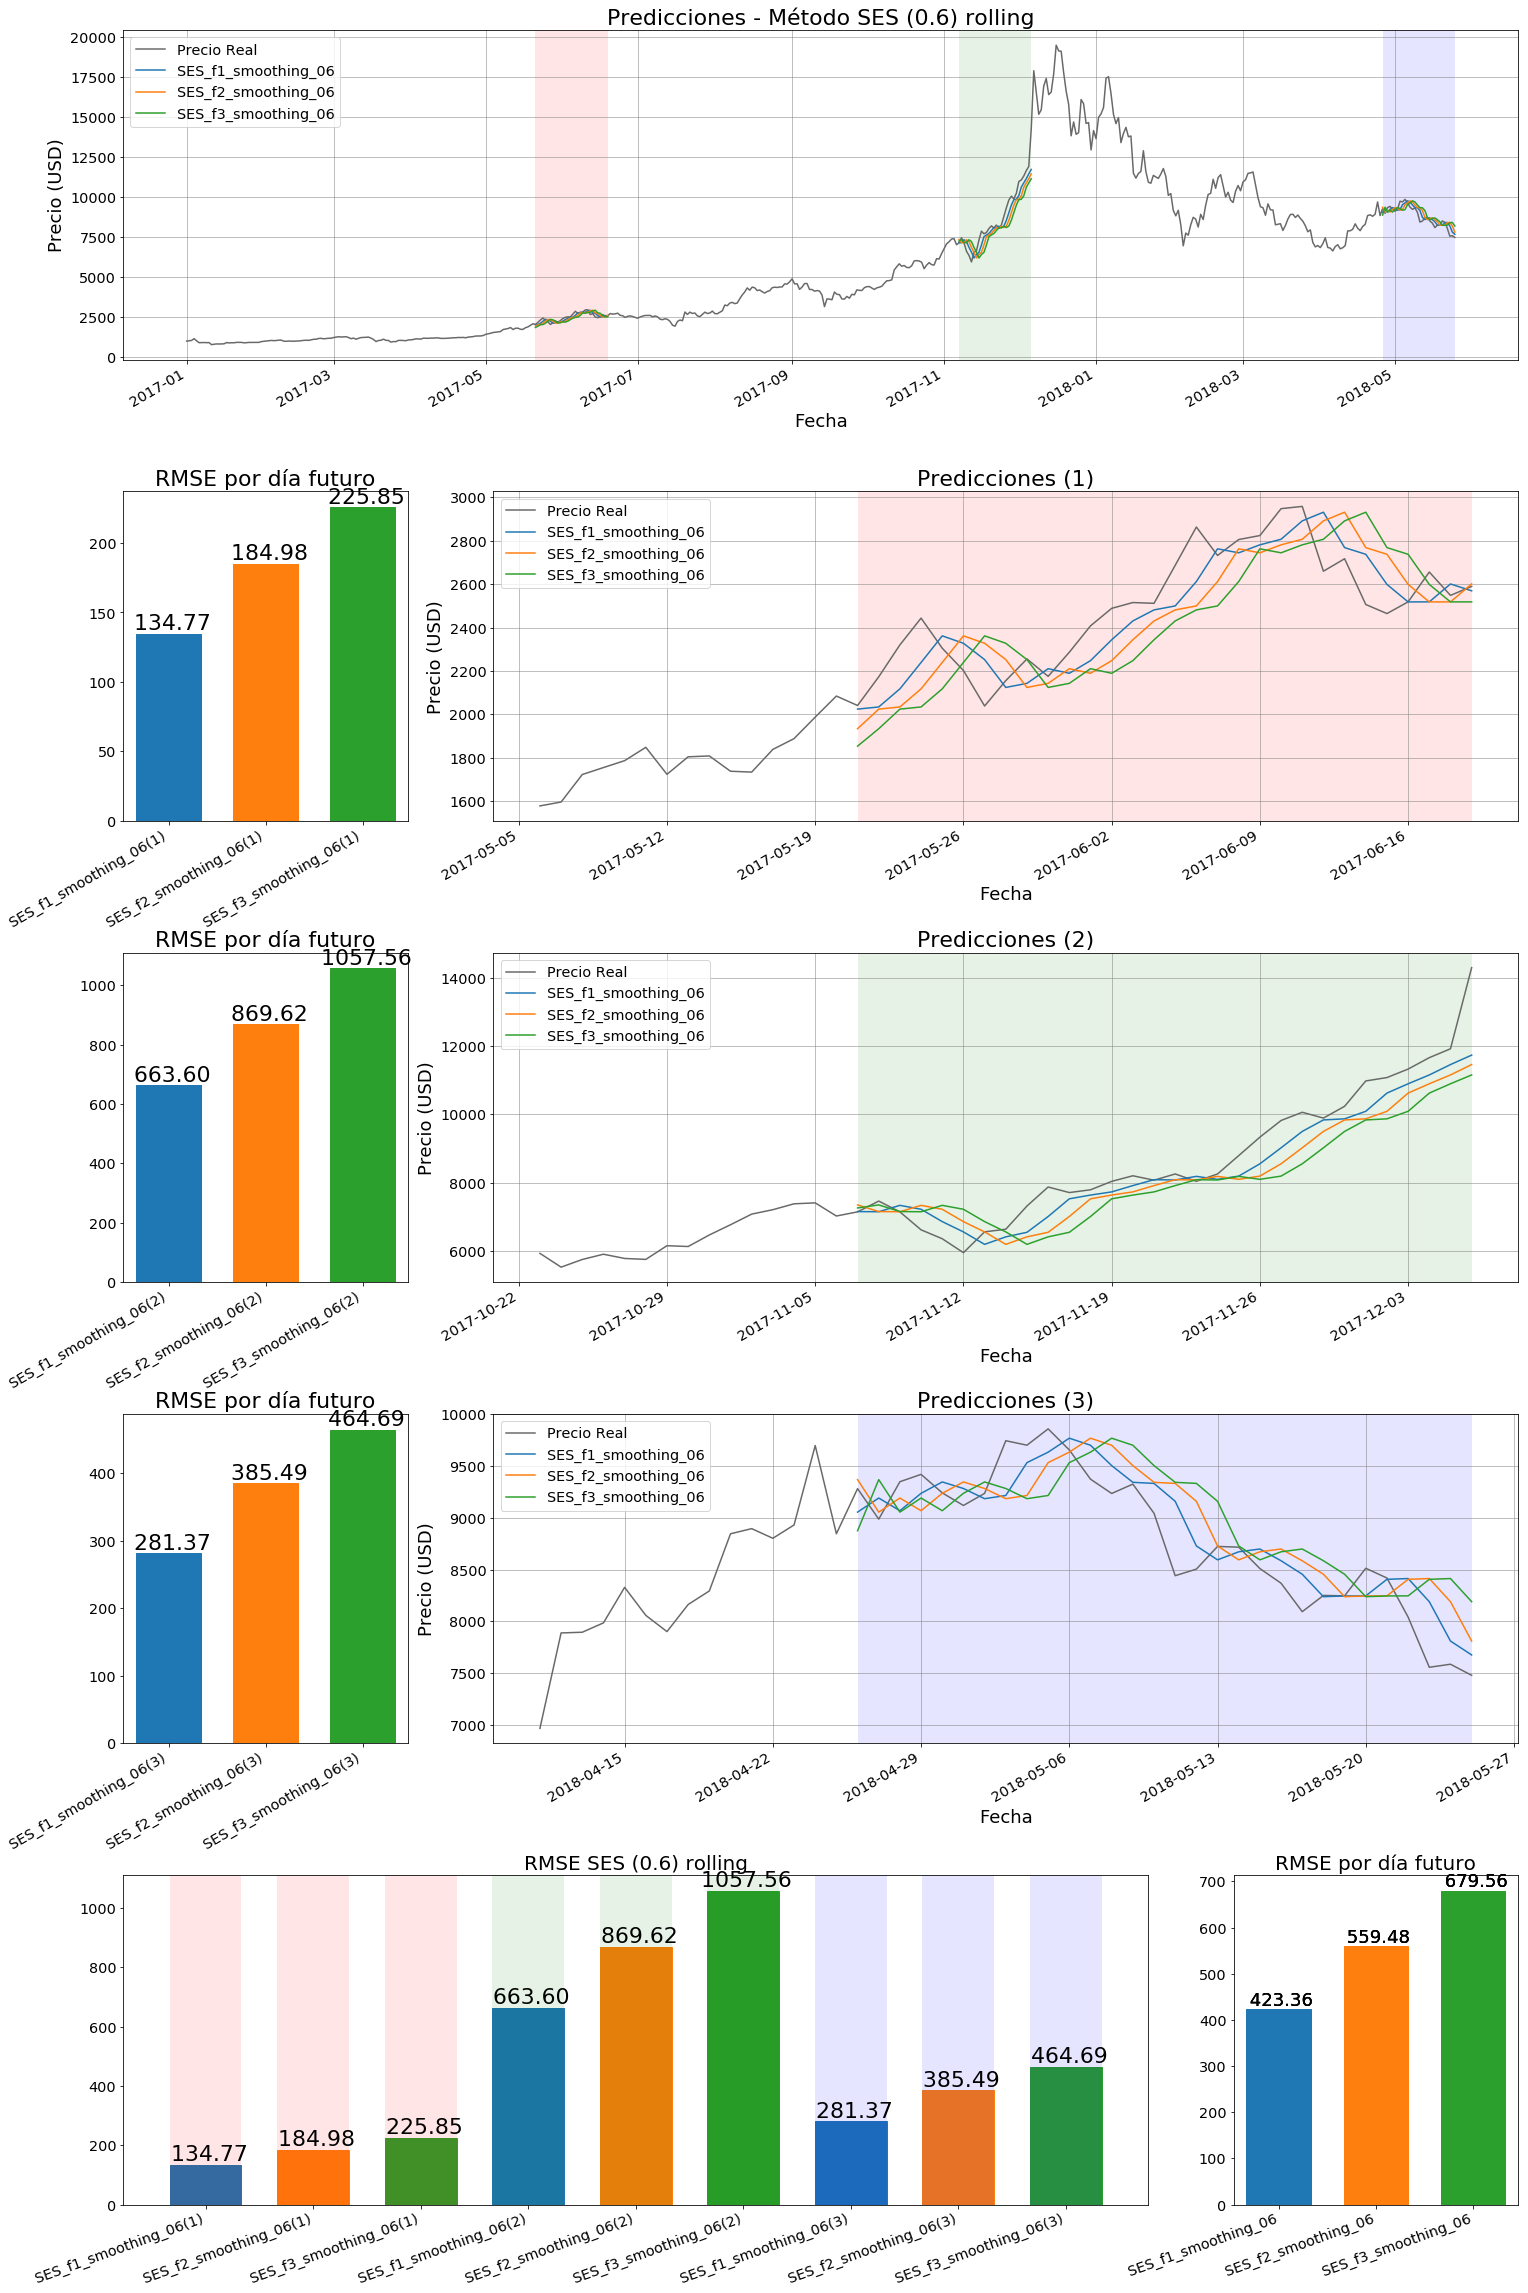

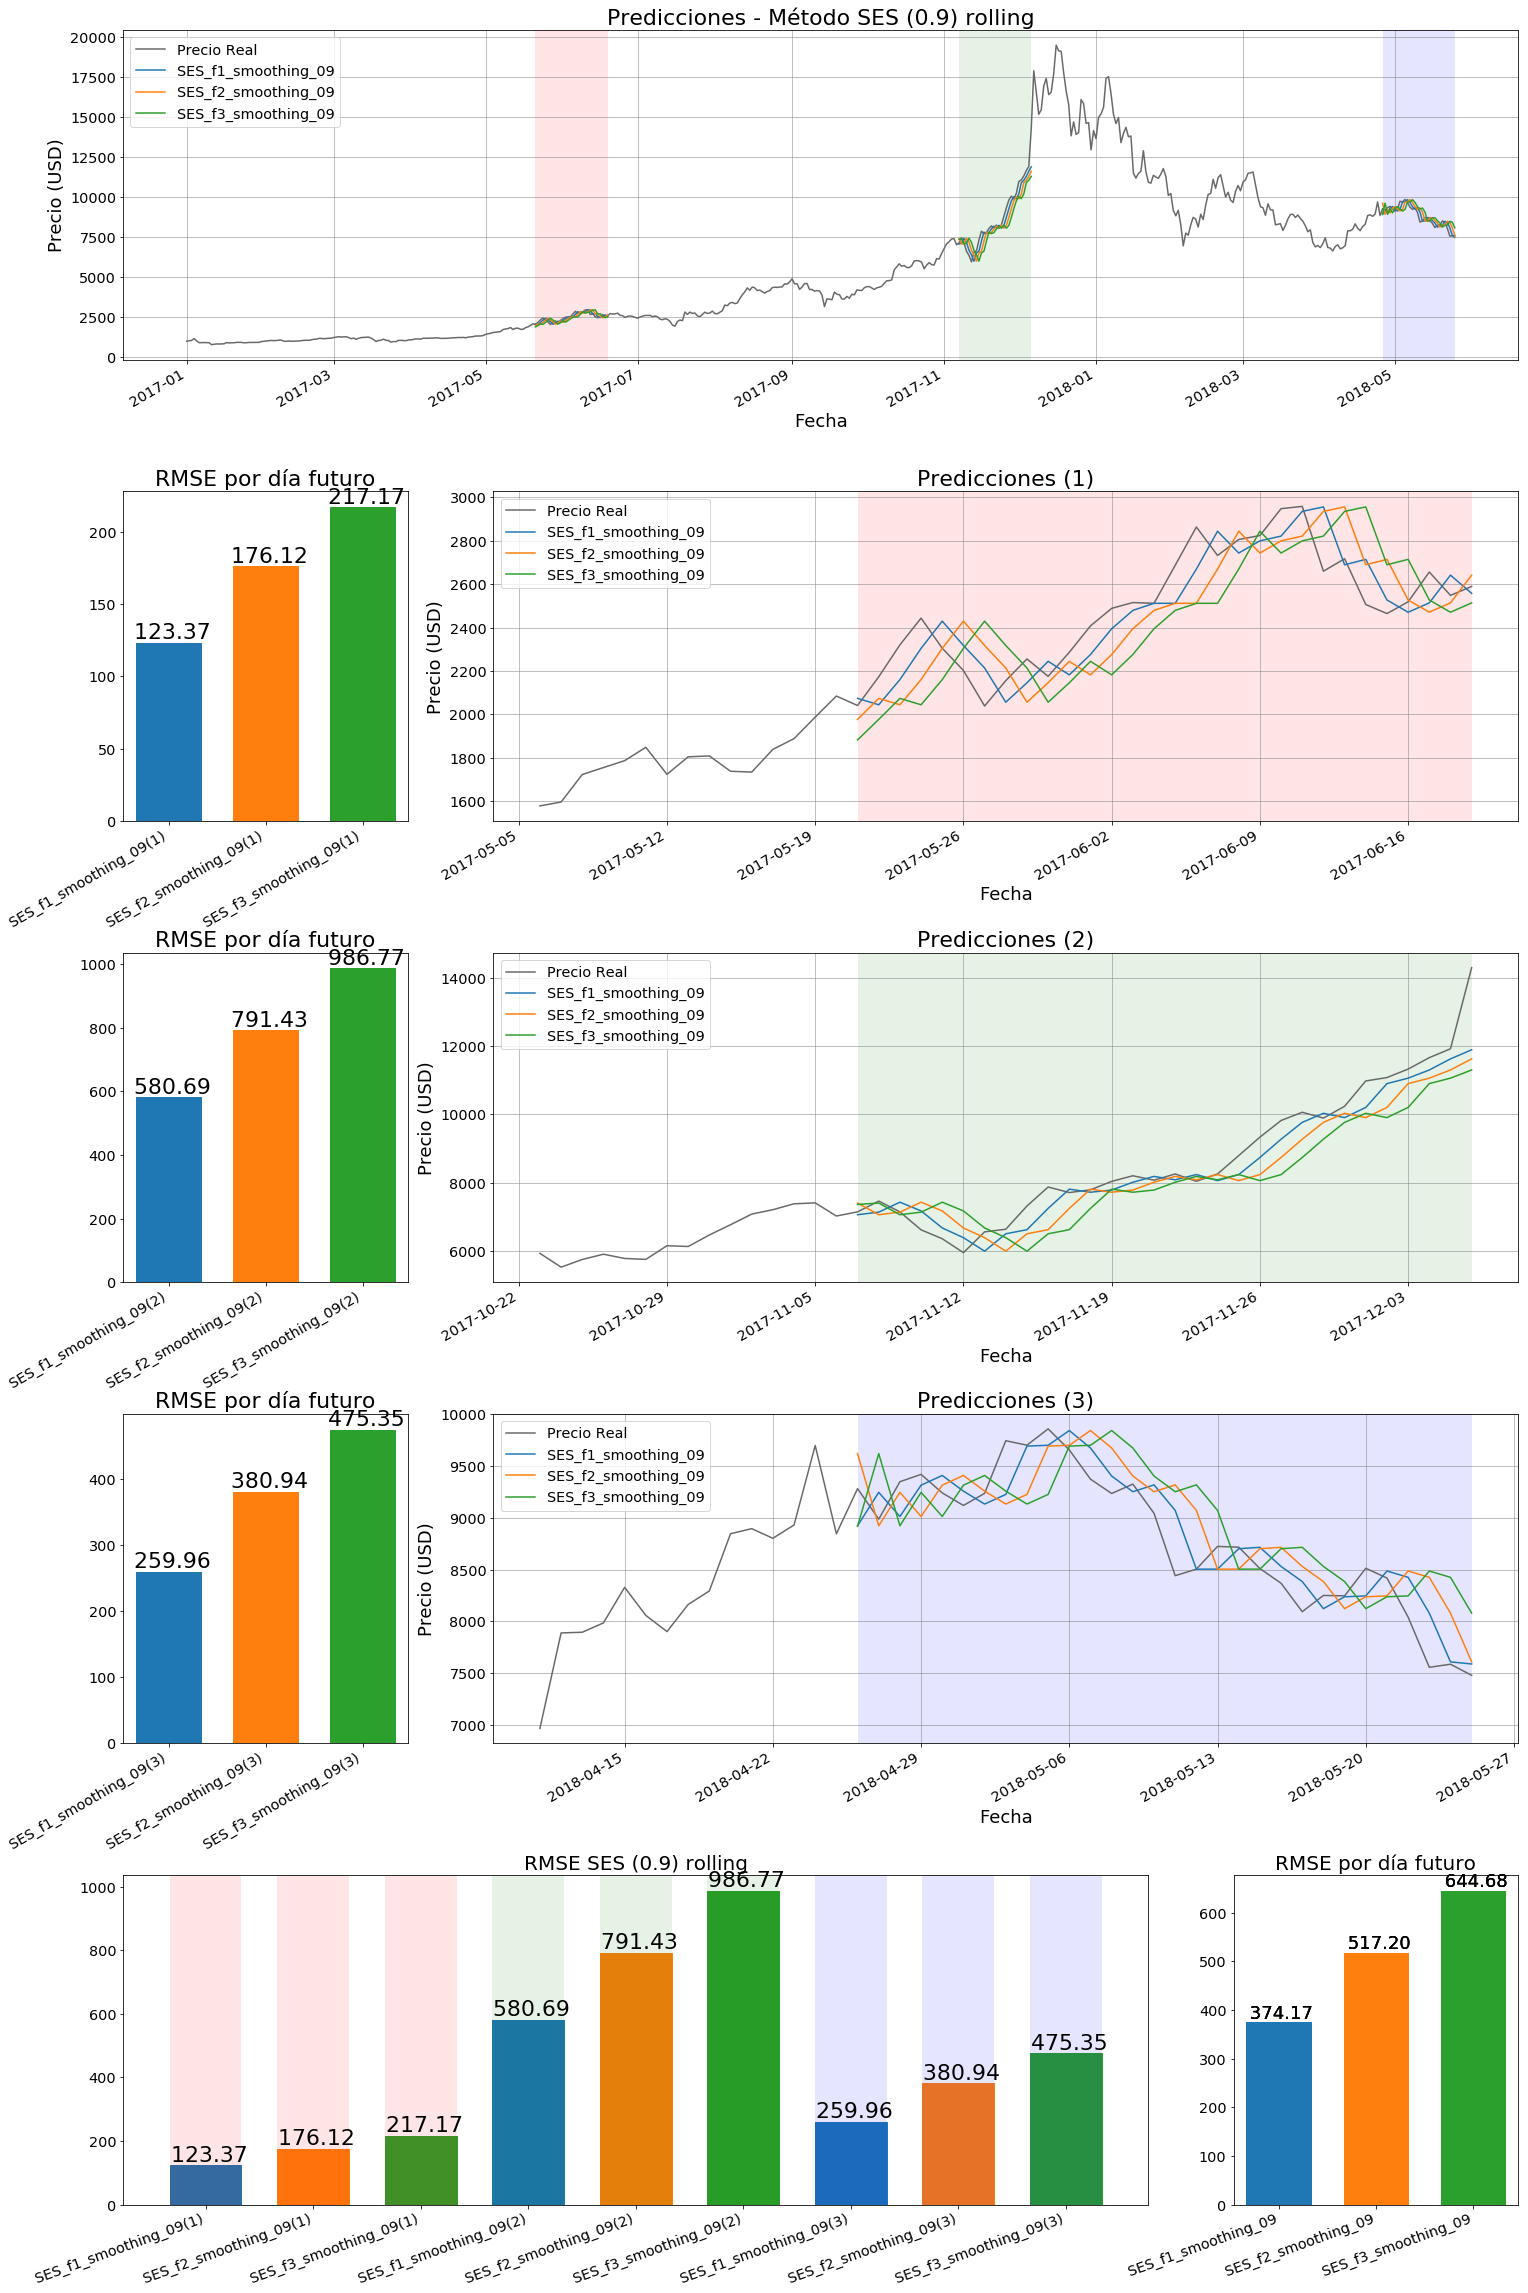

In [6]:
# Simple Exponential Smoothing 0.2
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_f' + str(f) + "_smoothing_02"] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]    
            ses02 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.2,optimized=False)
            test['SES_f' + str(f) + "_smoothing_02"][i] = ses02.forecast(1)
    predicciones = predicciones.append(test)
                    
predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_02_rolling.csv')

graficarBaselines(predicciones,"SES (0.2) rolling")

# Simple Exponential Smoothing 0.6
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_f' + str(f) + "_smoothing_06"] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]    
            ses06 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.6,optimized=False)
            test['SES_f' + str(f) + "_smoothing_06"][i] = ses06.forecast(1)
    predicciones = predicciones.append(test)
                    
predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_06_rolling.csv')

graficarBaselines(predicciones,"SES (0.6) rolling")

# Simple Exponential Smoothing 0.9
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['SES_f' + str(f) + "_smoothing_09"] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]    
            ses09 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=0.9,optimized=False)
            test['SES_f' + str(f) + "_smoothing_09"][i] = ses09.forecast(1)
    predicciones = predicciones.append(test)
                    
predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_09_rolling.csv')

graficarBaselines(predicciones,"SES (0.9) rolling")

Se puede ver que el mejor resultado lo da alfa=0.2. Sin embargo no se mejora el error del método "naive".
En general, estos métodos no funcionan bien para conjuntos de datos con mucha variabilidad.
Para conjuntos de datos que siguen una tendencia, es decir, que tienen un patrón general de movimiento de subida o de bajada (como en este caso), se puede usar el método de "Tendencia Lineal de Holt": es una extensión del método de suavizamiento exponencial simple aplicado al promedio de la serie ("nivel") y a la tendencia. La ecuación de nivel y la de tendencia se suman para general la ecuación de predicción. La suma es apropiada para conjuntos de datos con una tendencia que incrementa o decrementa linealmente, aunque también se puede usar la multiplicación de las ecuaciones de nivel y tendencia si el conjunto de datos muestra una tendencia exponencial. Se compararán los dos métodos.

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

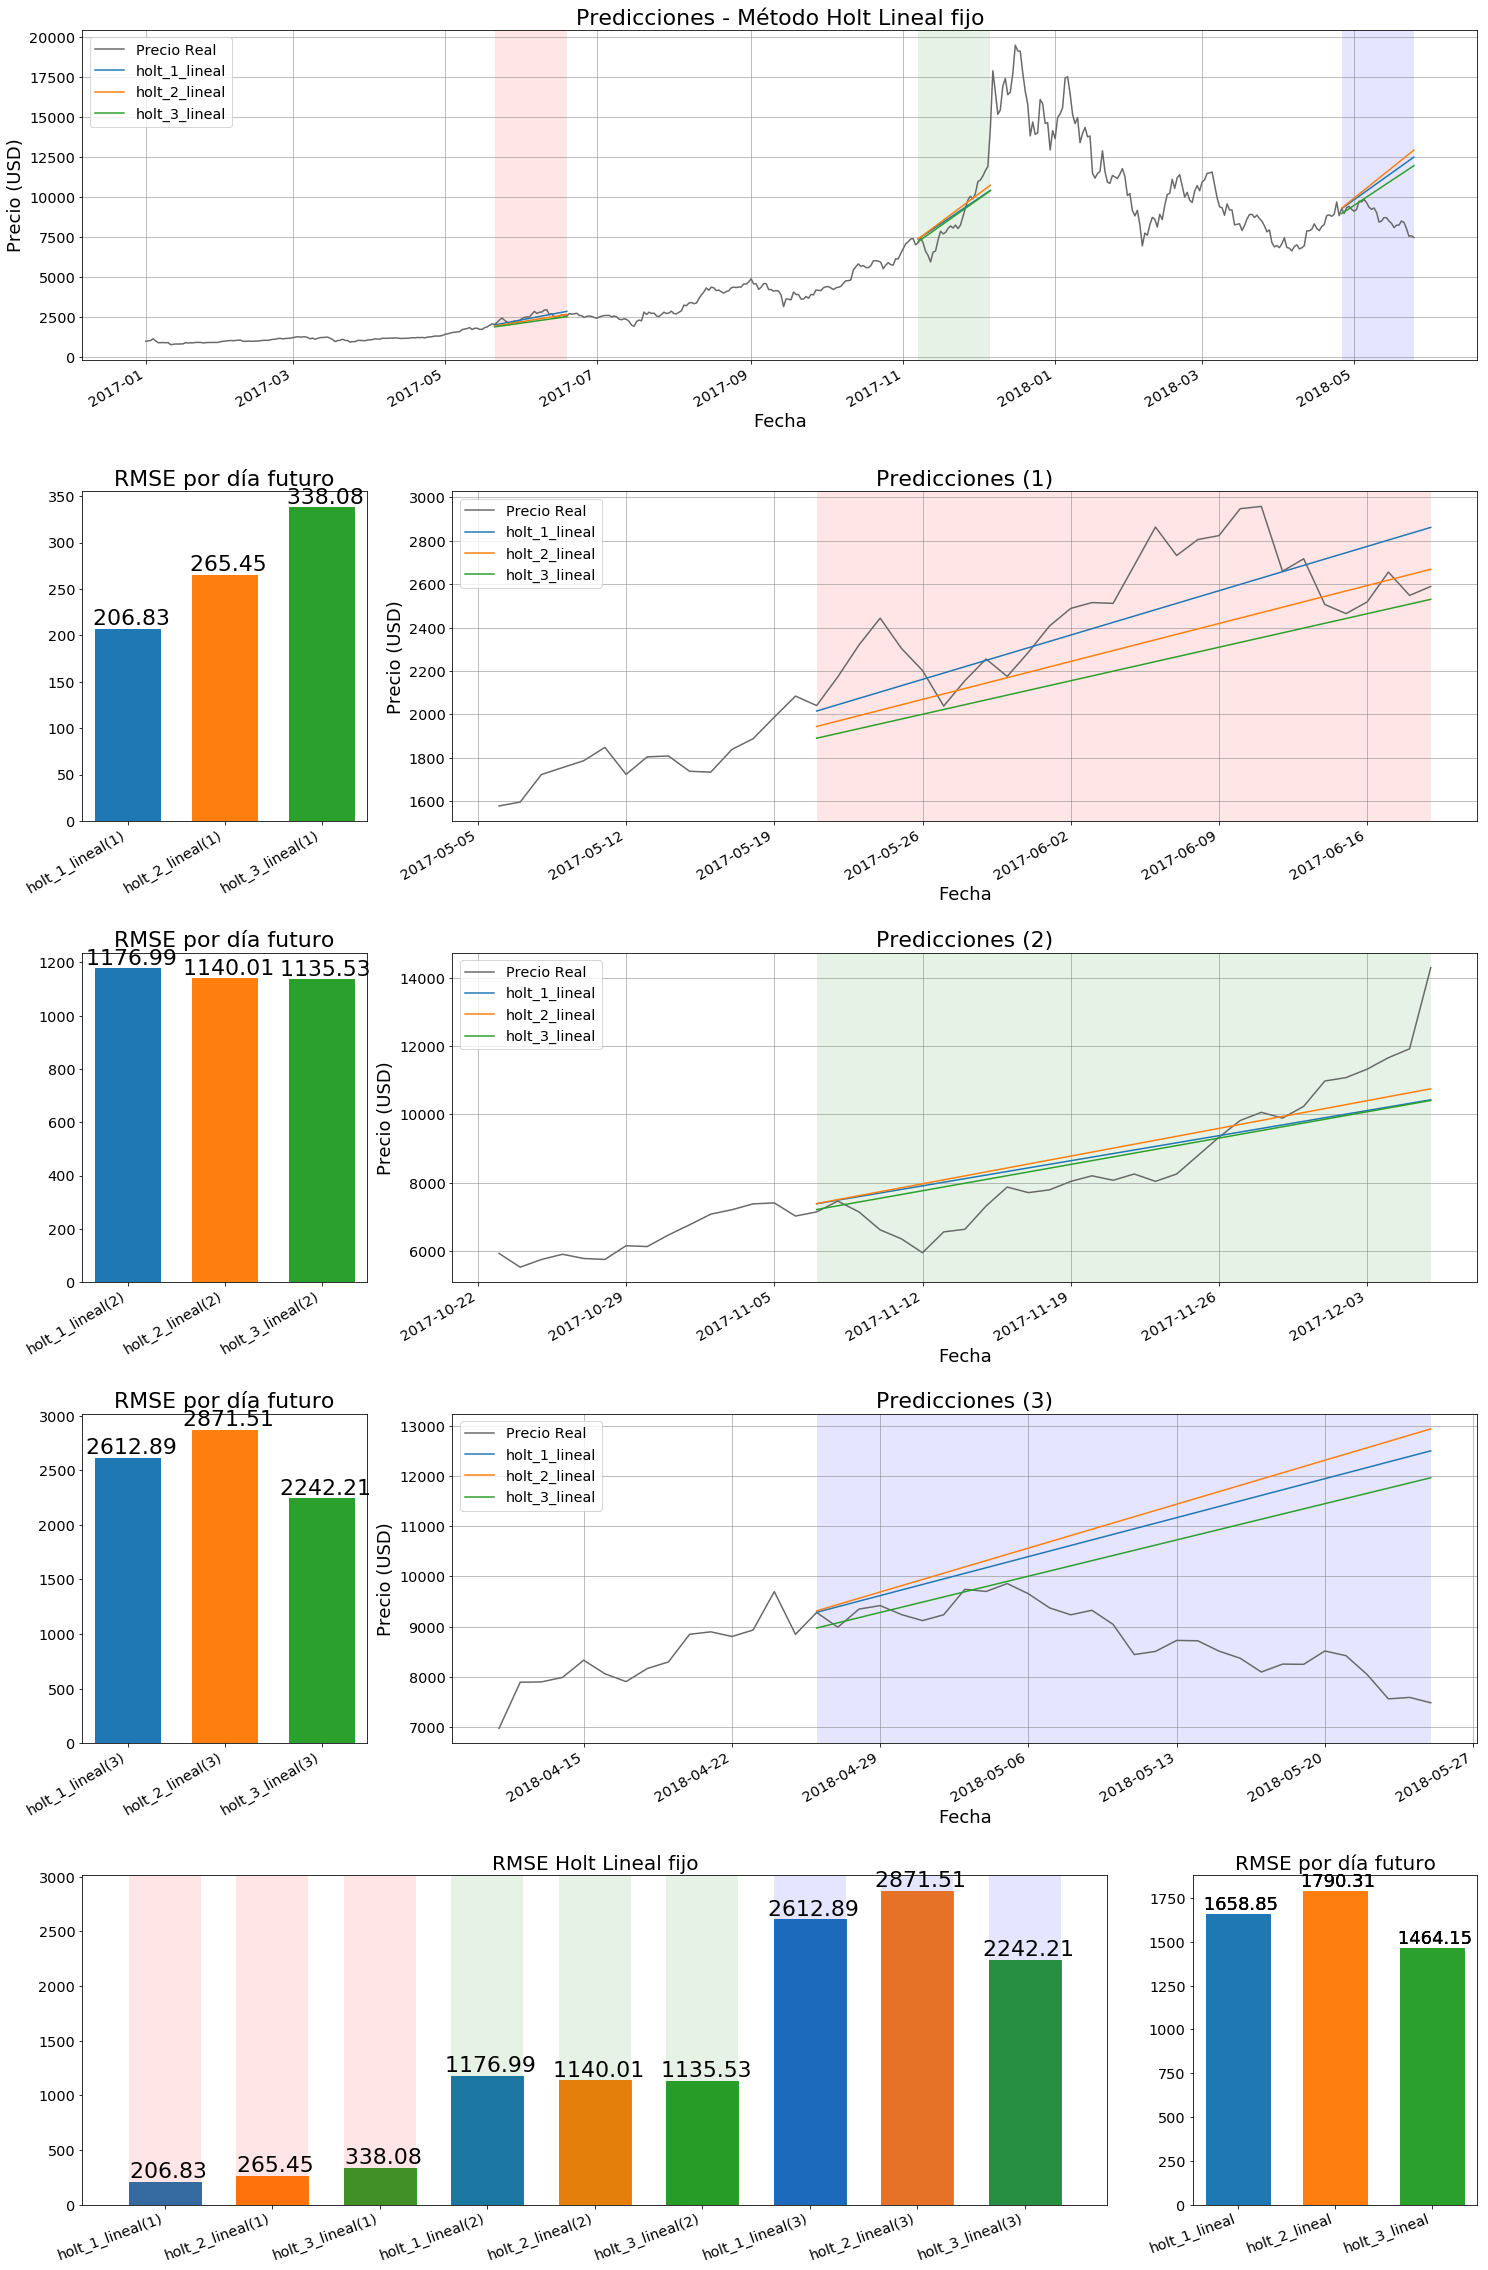

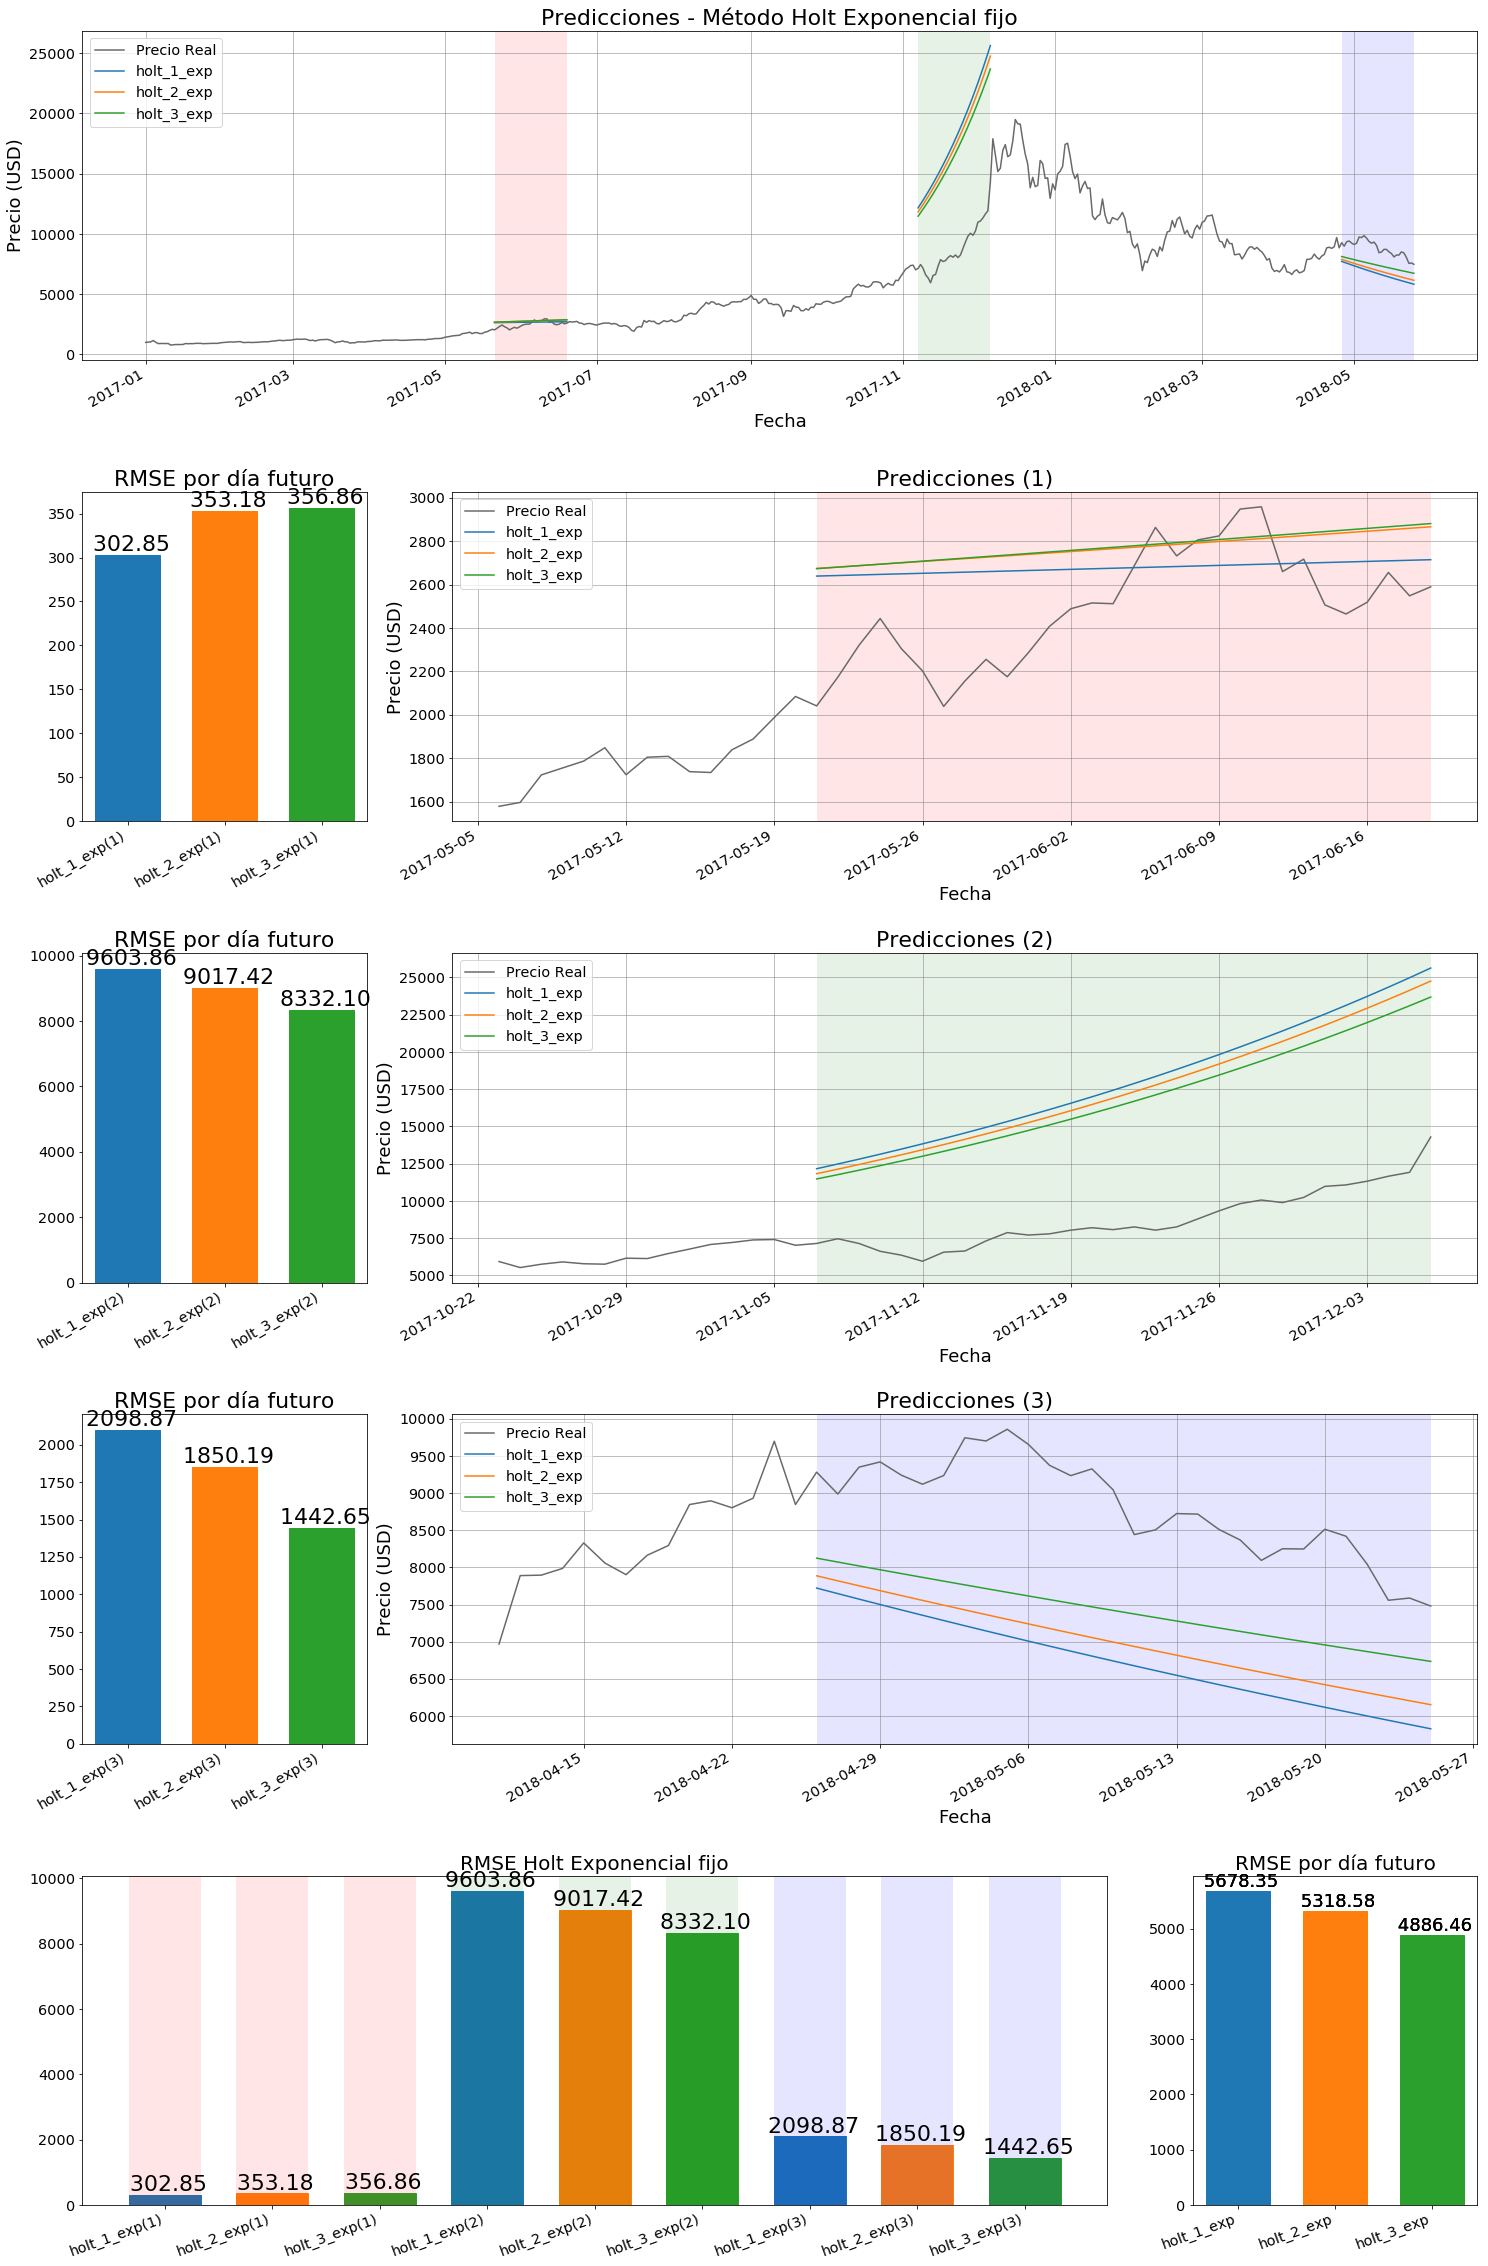

In [7]:
# Holt lineal (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holt_' + str(f) + '_lineal'] = np.nan
        training = dataset[0:-test_size-f+1]
        holt_lineal = Holt(np.asarray(training)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
        test['holt_' + str(f) + '_lineal'] = holt_lineal.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_lineal_fijo.csv')

graficarBaselines(predicciones,"Holt Lineal fijo")

# Holt exponencial (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holt_' + str(f) + '_exp'] = np.nan
        training = dataset[0:-test_size+i-f+1]
        holt_exp = Holt(np.asarray(training), exponential=True).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
        test['holt_' + str(f) + '_exp'] = holt_exp.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_exp_fijo.csv')

graficarBaselines(predicciones,"Holt Exponencial fijo") 

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

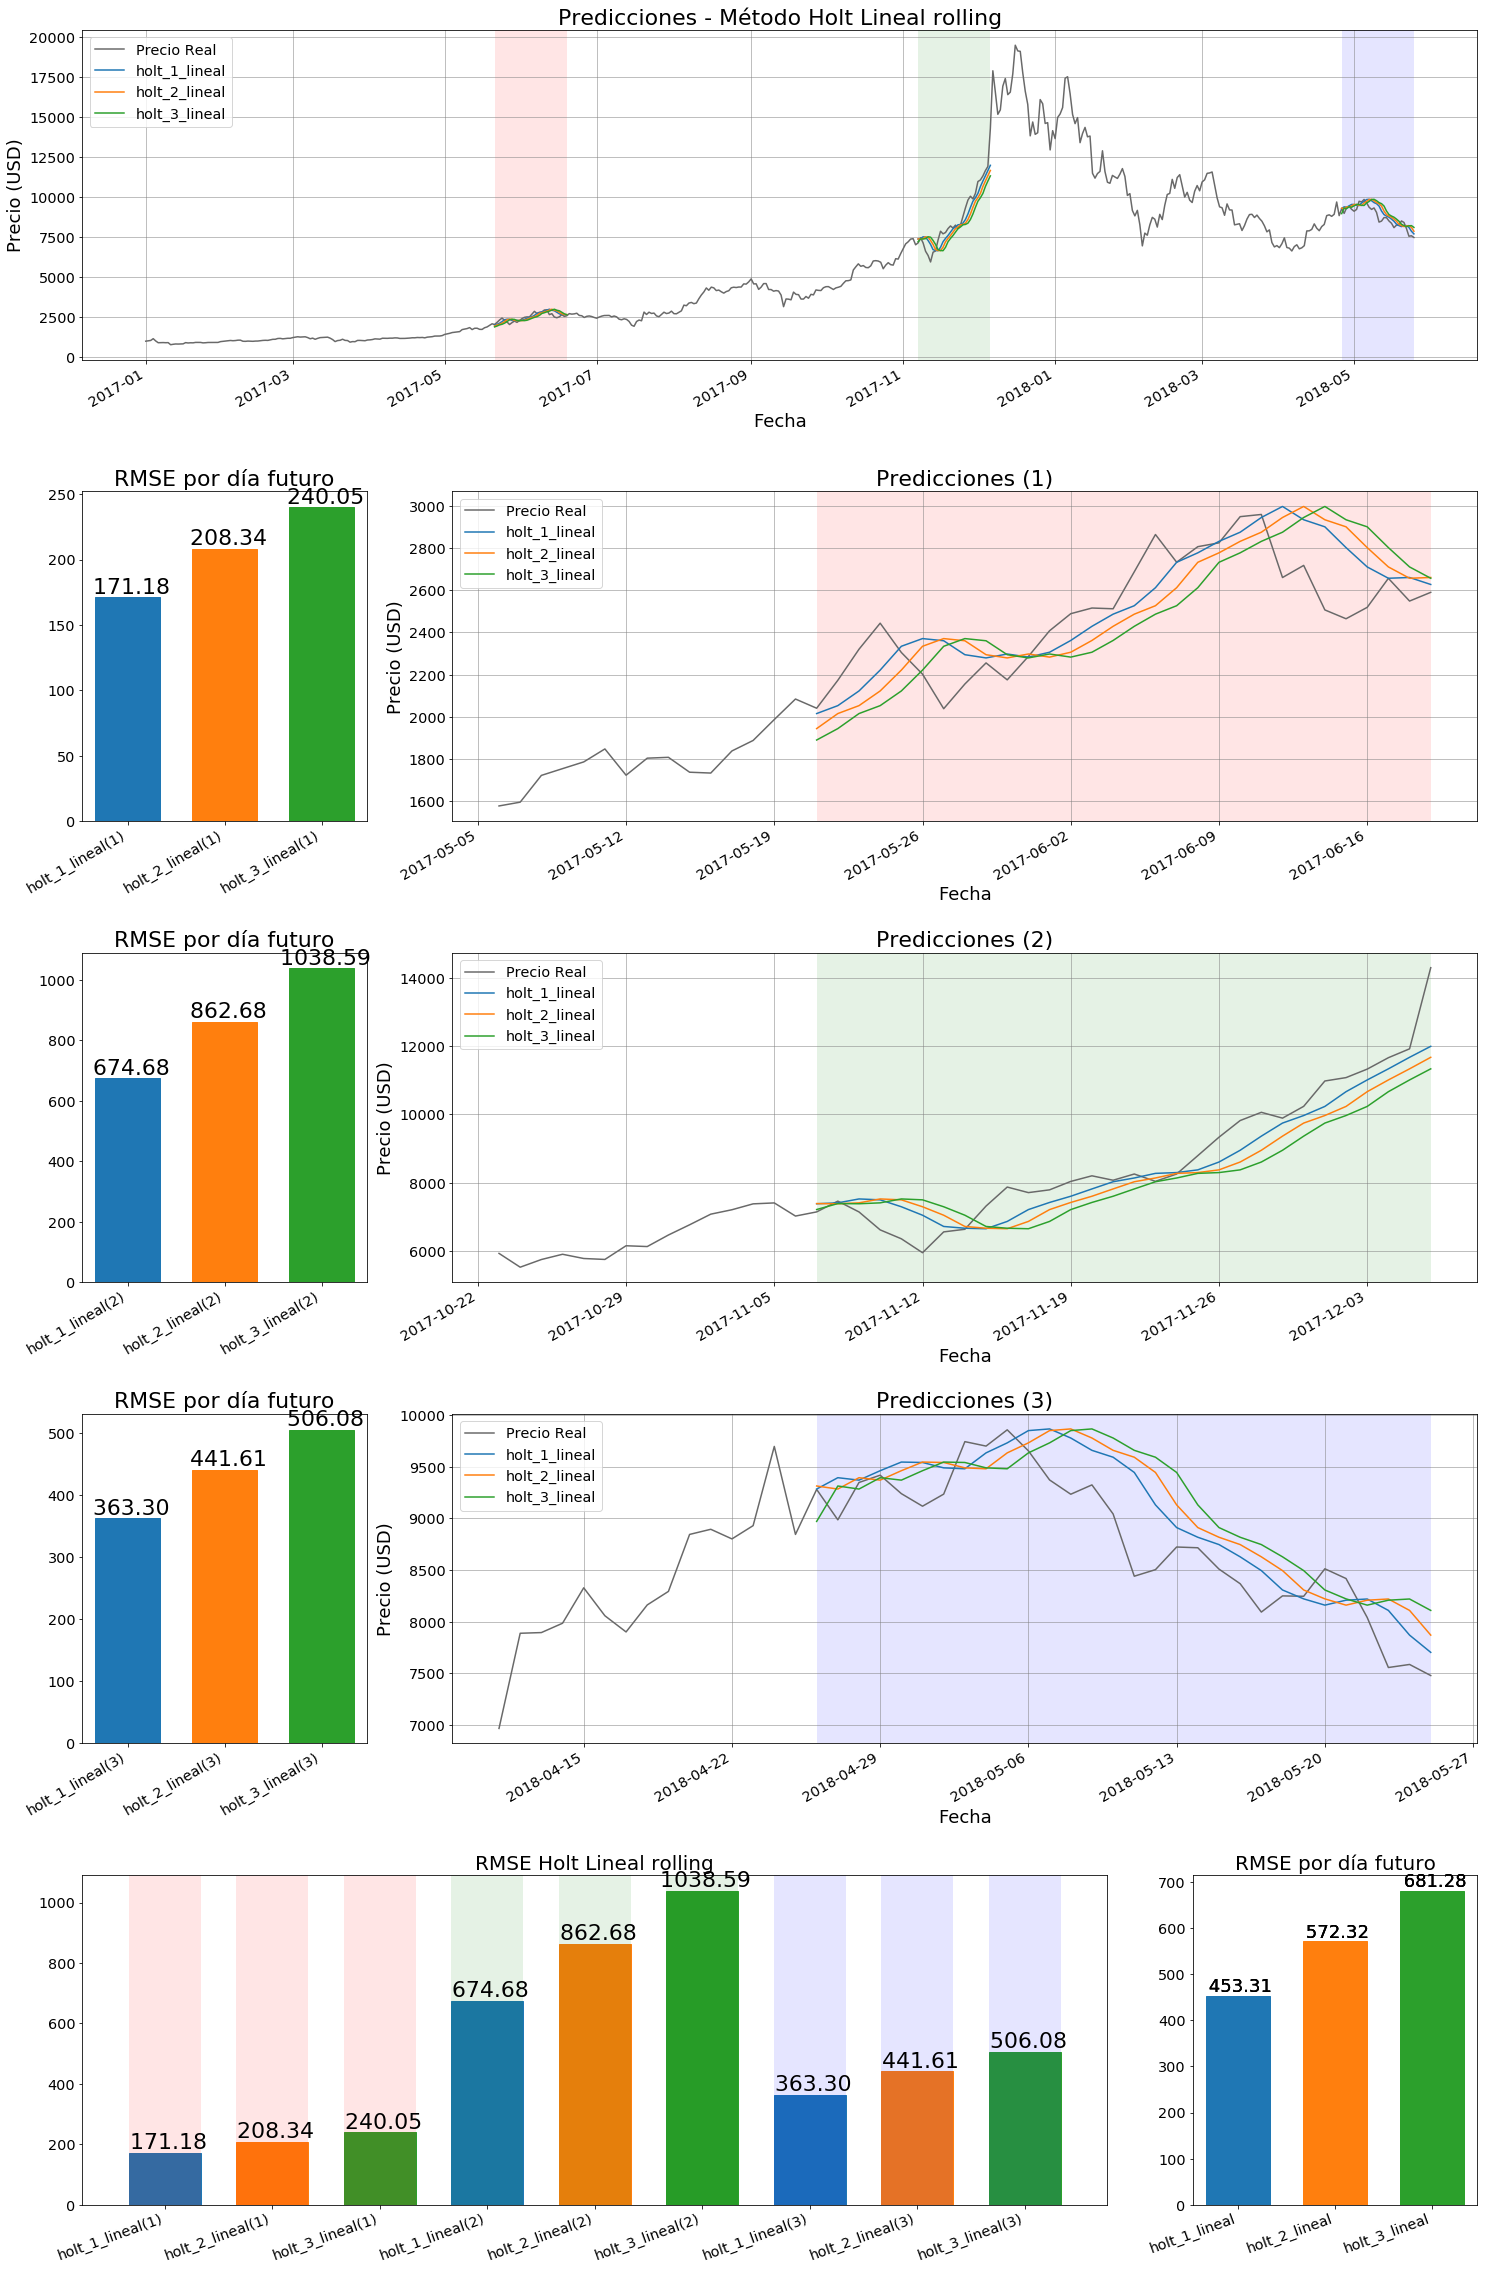

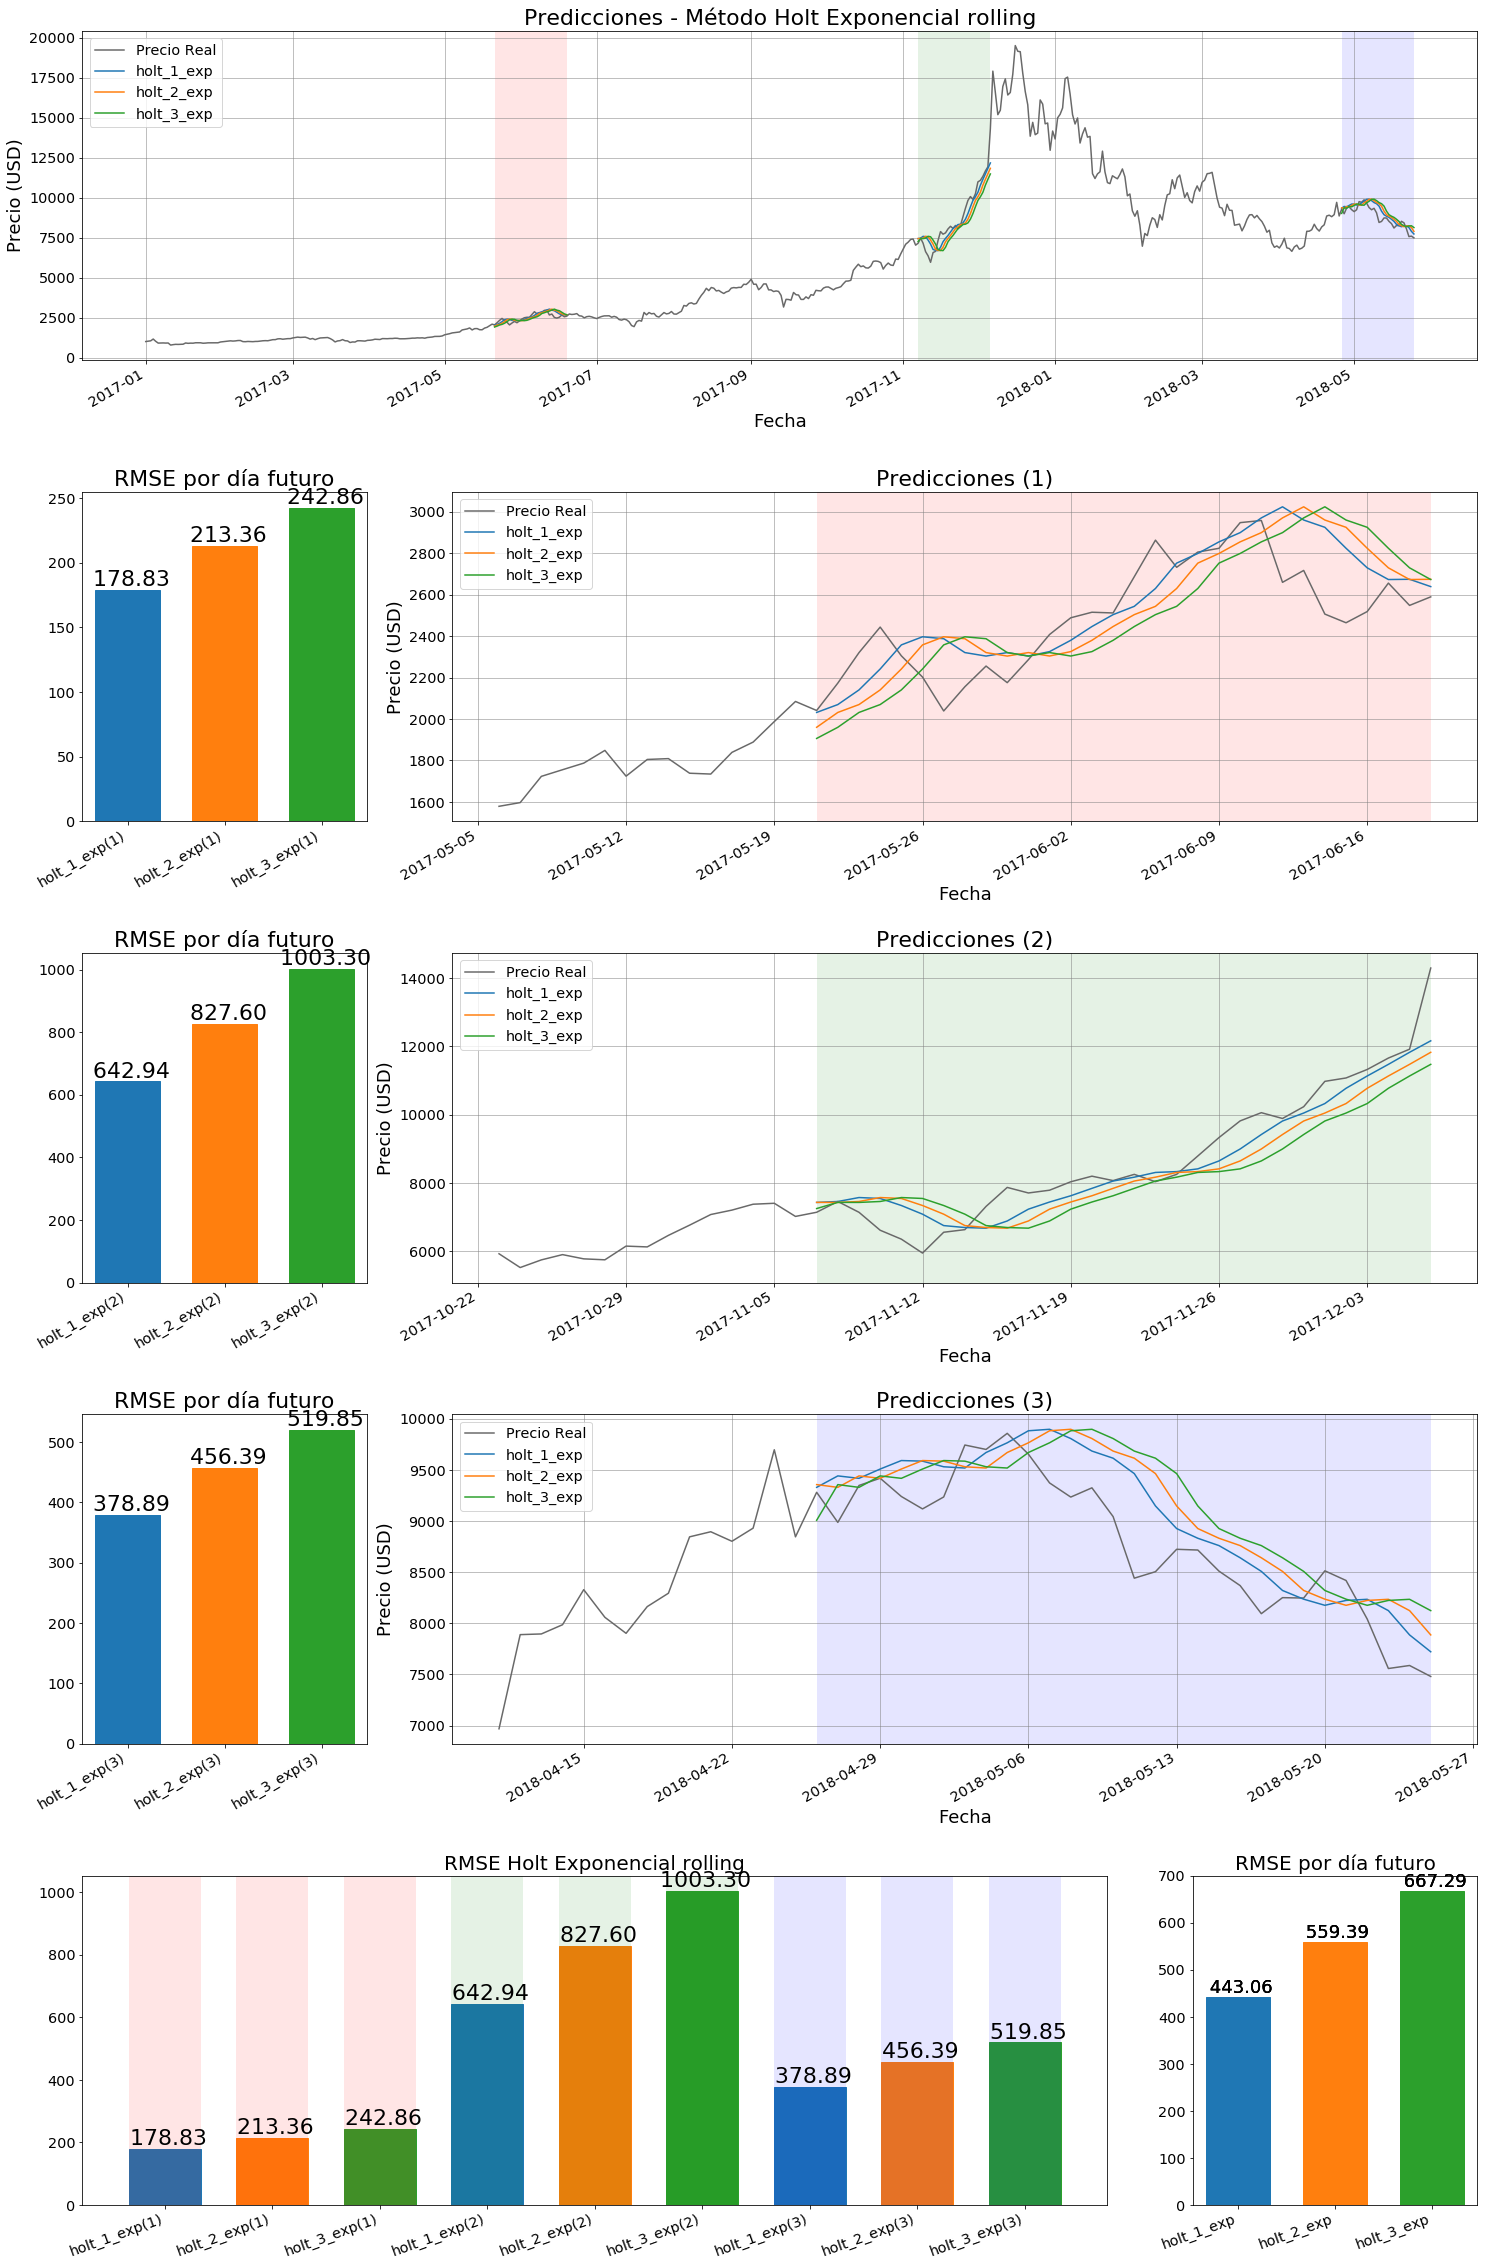

In [8]:
# Holt lineal (conjunto de entrenamiento móvil)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holt_' + str(f) + '_lineal'] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]
            holt_lineal = Holt(np.asarray(training)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
            test['holt_' + str(f) + '_lineal'][i] = holt_lineal.forecast(1)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_lineal_rolling.csv')

graficarBaselines(predicciones,"Holt Lineal rolling")

# Holt exponencial (conjunto de entrenamiento móvil)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holt_' + str(f) + '_exp'] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]
            holt_exp = Holt(np.asarray(training), exponential=True).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
            test['holt_' + str(f) + '_exp'][i] = holt_exp.forecast(1)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_exp_rolling.csv')

graficarBaselines(predicciones,"Holt Exponencial rolling") 

Se puede ver que este método no sirve para este conjunto de datos ya que la tendencia cambia con frecuencia, no sigue un patrón. Se puede intentar el método de Holt-Winter, que toma en cuenta la temporada en el cálculo (por ej. las visitas a un hotel en la playa van a ser influenciadas por la estación del año). A las ecuaciones de nivel y de tendencia, se suma la ecuación de estacionalidad. Como en el método de Holt, las ecuaciones pueden sumarse o multiplicarse, prefiriendo la multiplicación cuando las variaciones estacionales cambian con el nivel de la serie (en este caso parece ser así).

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

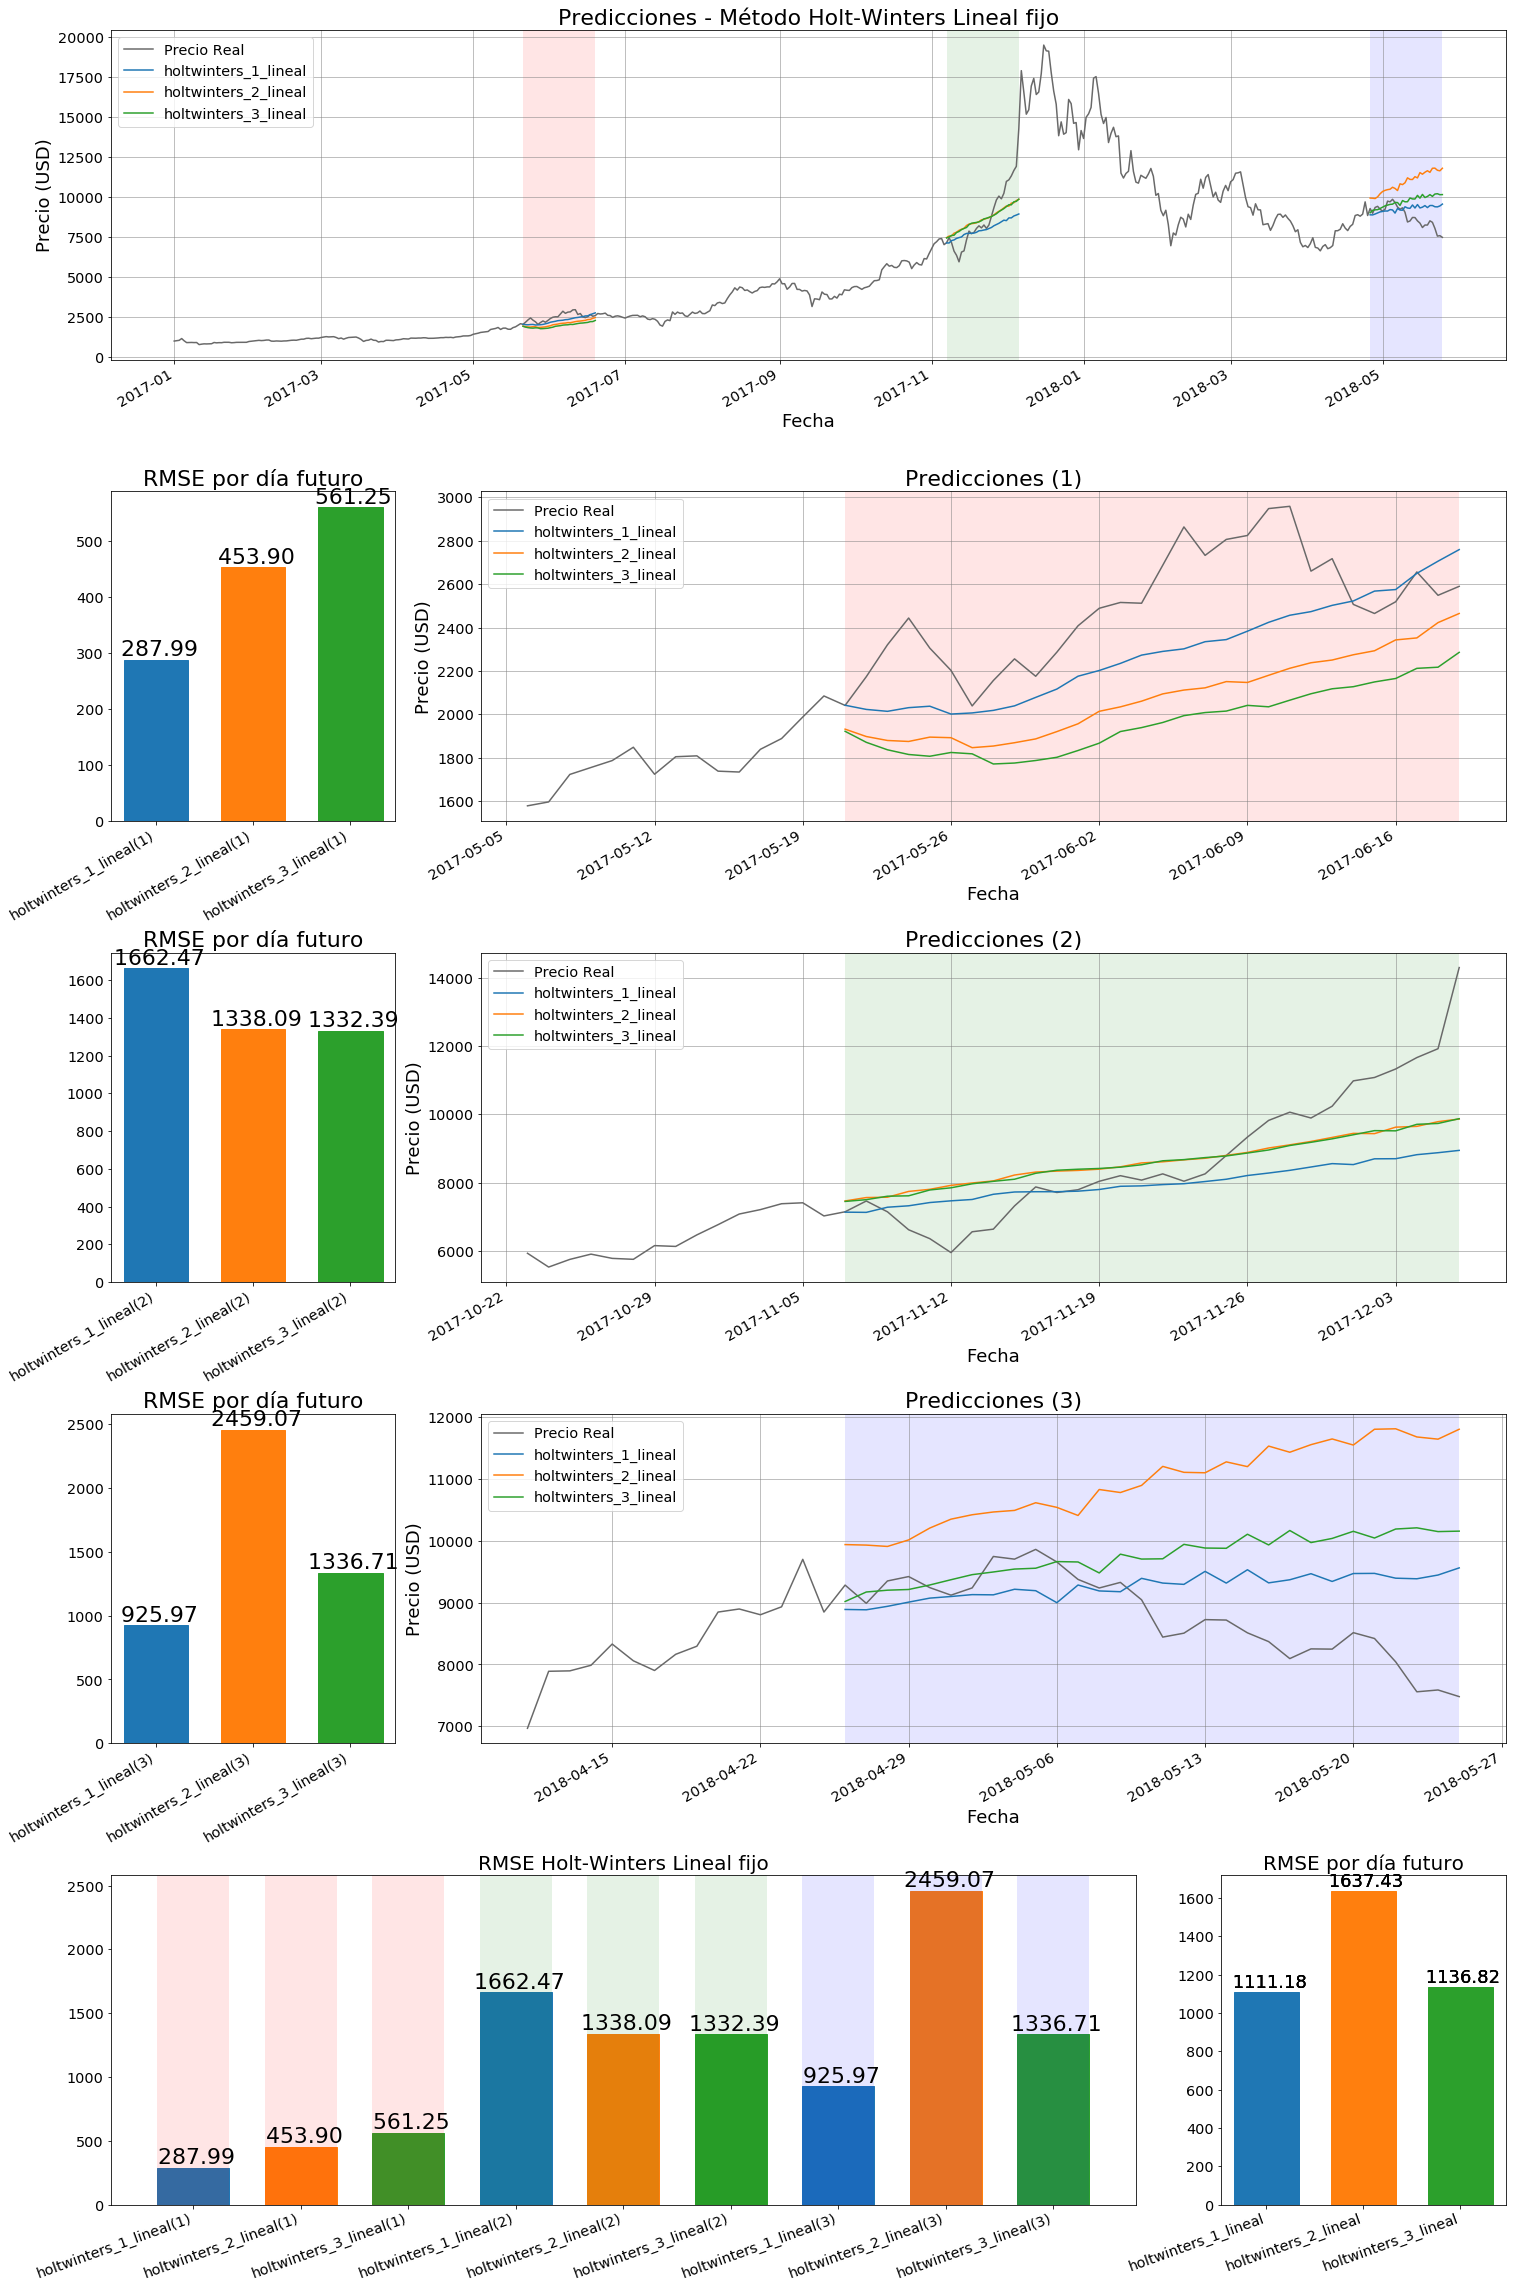

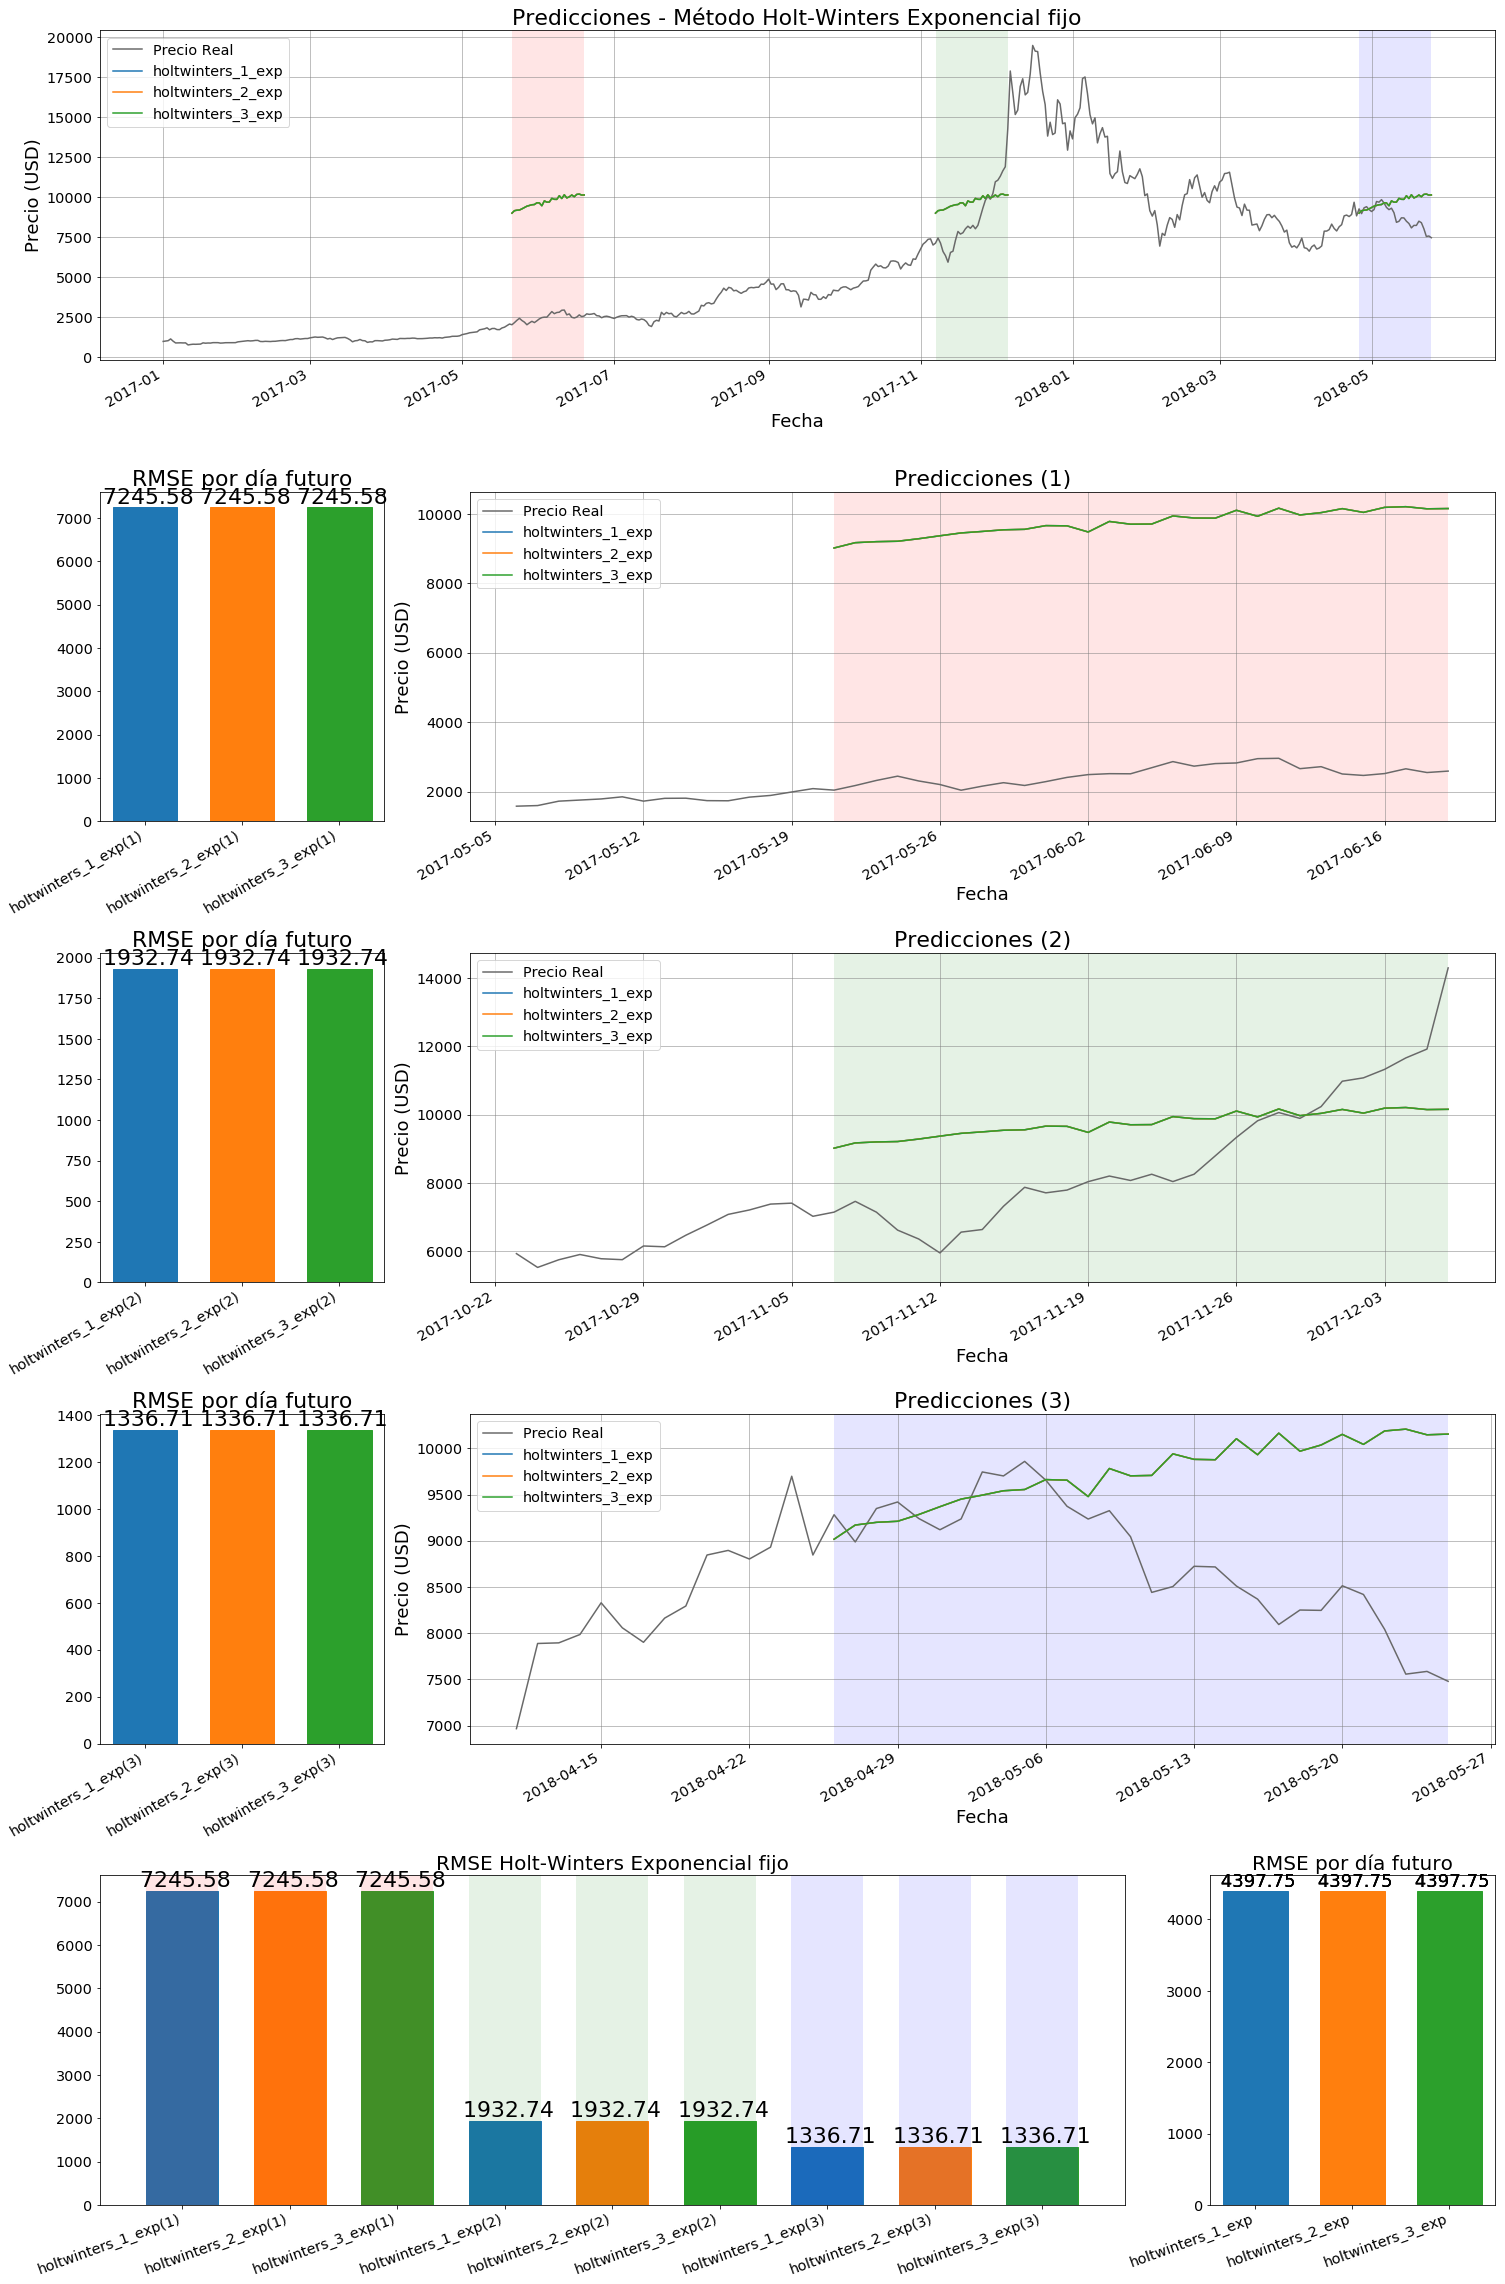

In [9]:
# Holt-Winters lineal (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holtwinters_' + str(f) + '_lineal'] = np.nan
        training = dataset[0:-test_size-f+1]
        hw_lineal = ExponentialSmoothing(np.asarray(training), seasonal_periods=45, trend='add', seasonal='add').fit()
        test['holtwinters_' + str(f) + '_lineal'] = hw_lineal.forecast(test_size)
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_lineal_fijo.csv')

graficarBaselines(predicciones,"Holt-Winters Lineal fijo")

# Holt-Winters exponencial (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holtwinters_' + str(f) + '_exp'] = np.nan
        training = dataset[0:-test_size-f+1]
        holt_exp = ExponentialSmoothing(np.asarray(training), seasonal_periods=45, trend='mul', seasonal='mul').fit() 
        test['holtwinters_' + str(f) + '_exp'] = hw_lineal.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_exp_fijo.csv')

graficarBaselines(predicciones,"Holt-Winters Exponencial fijo")

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

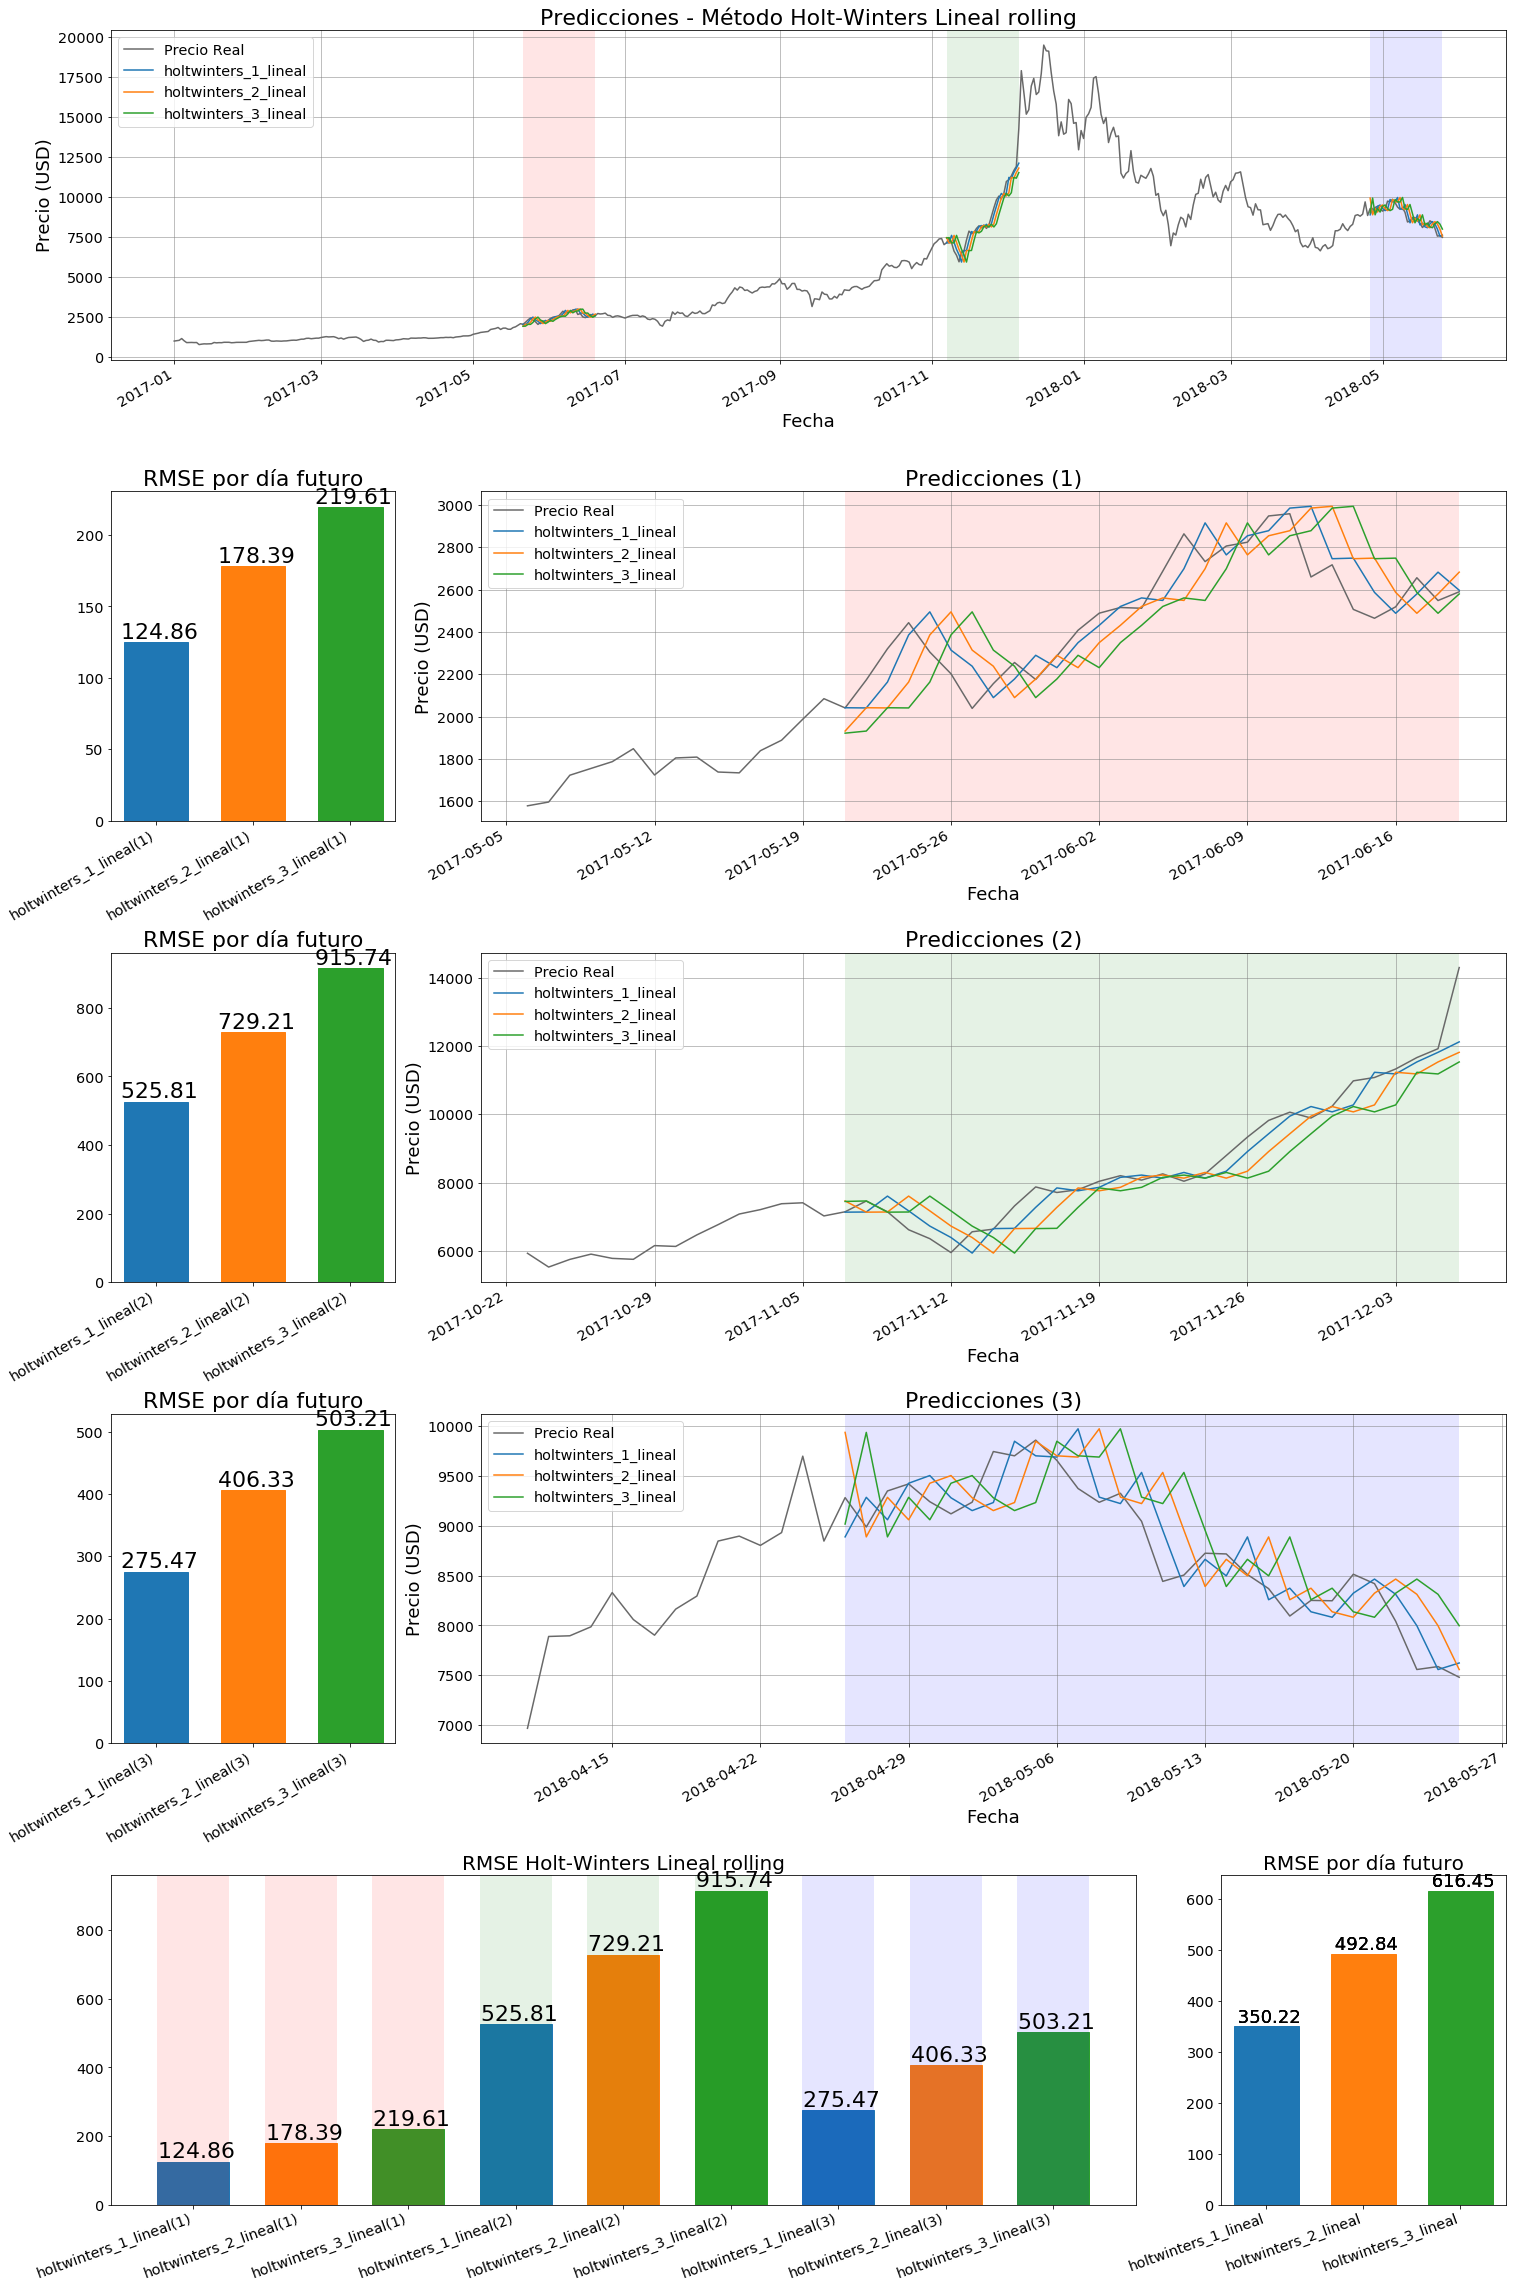

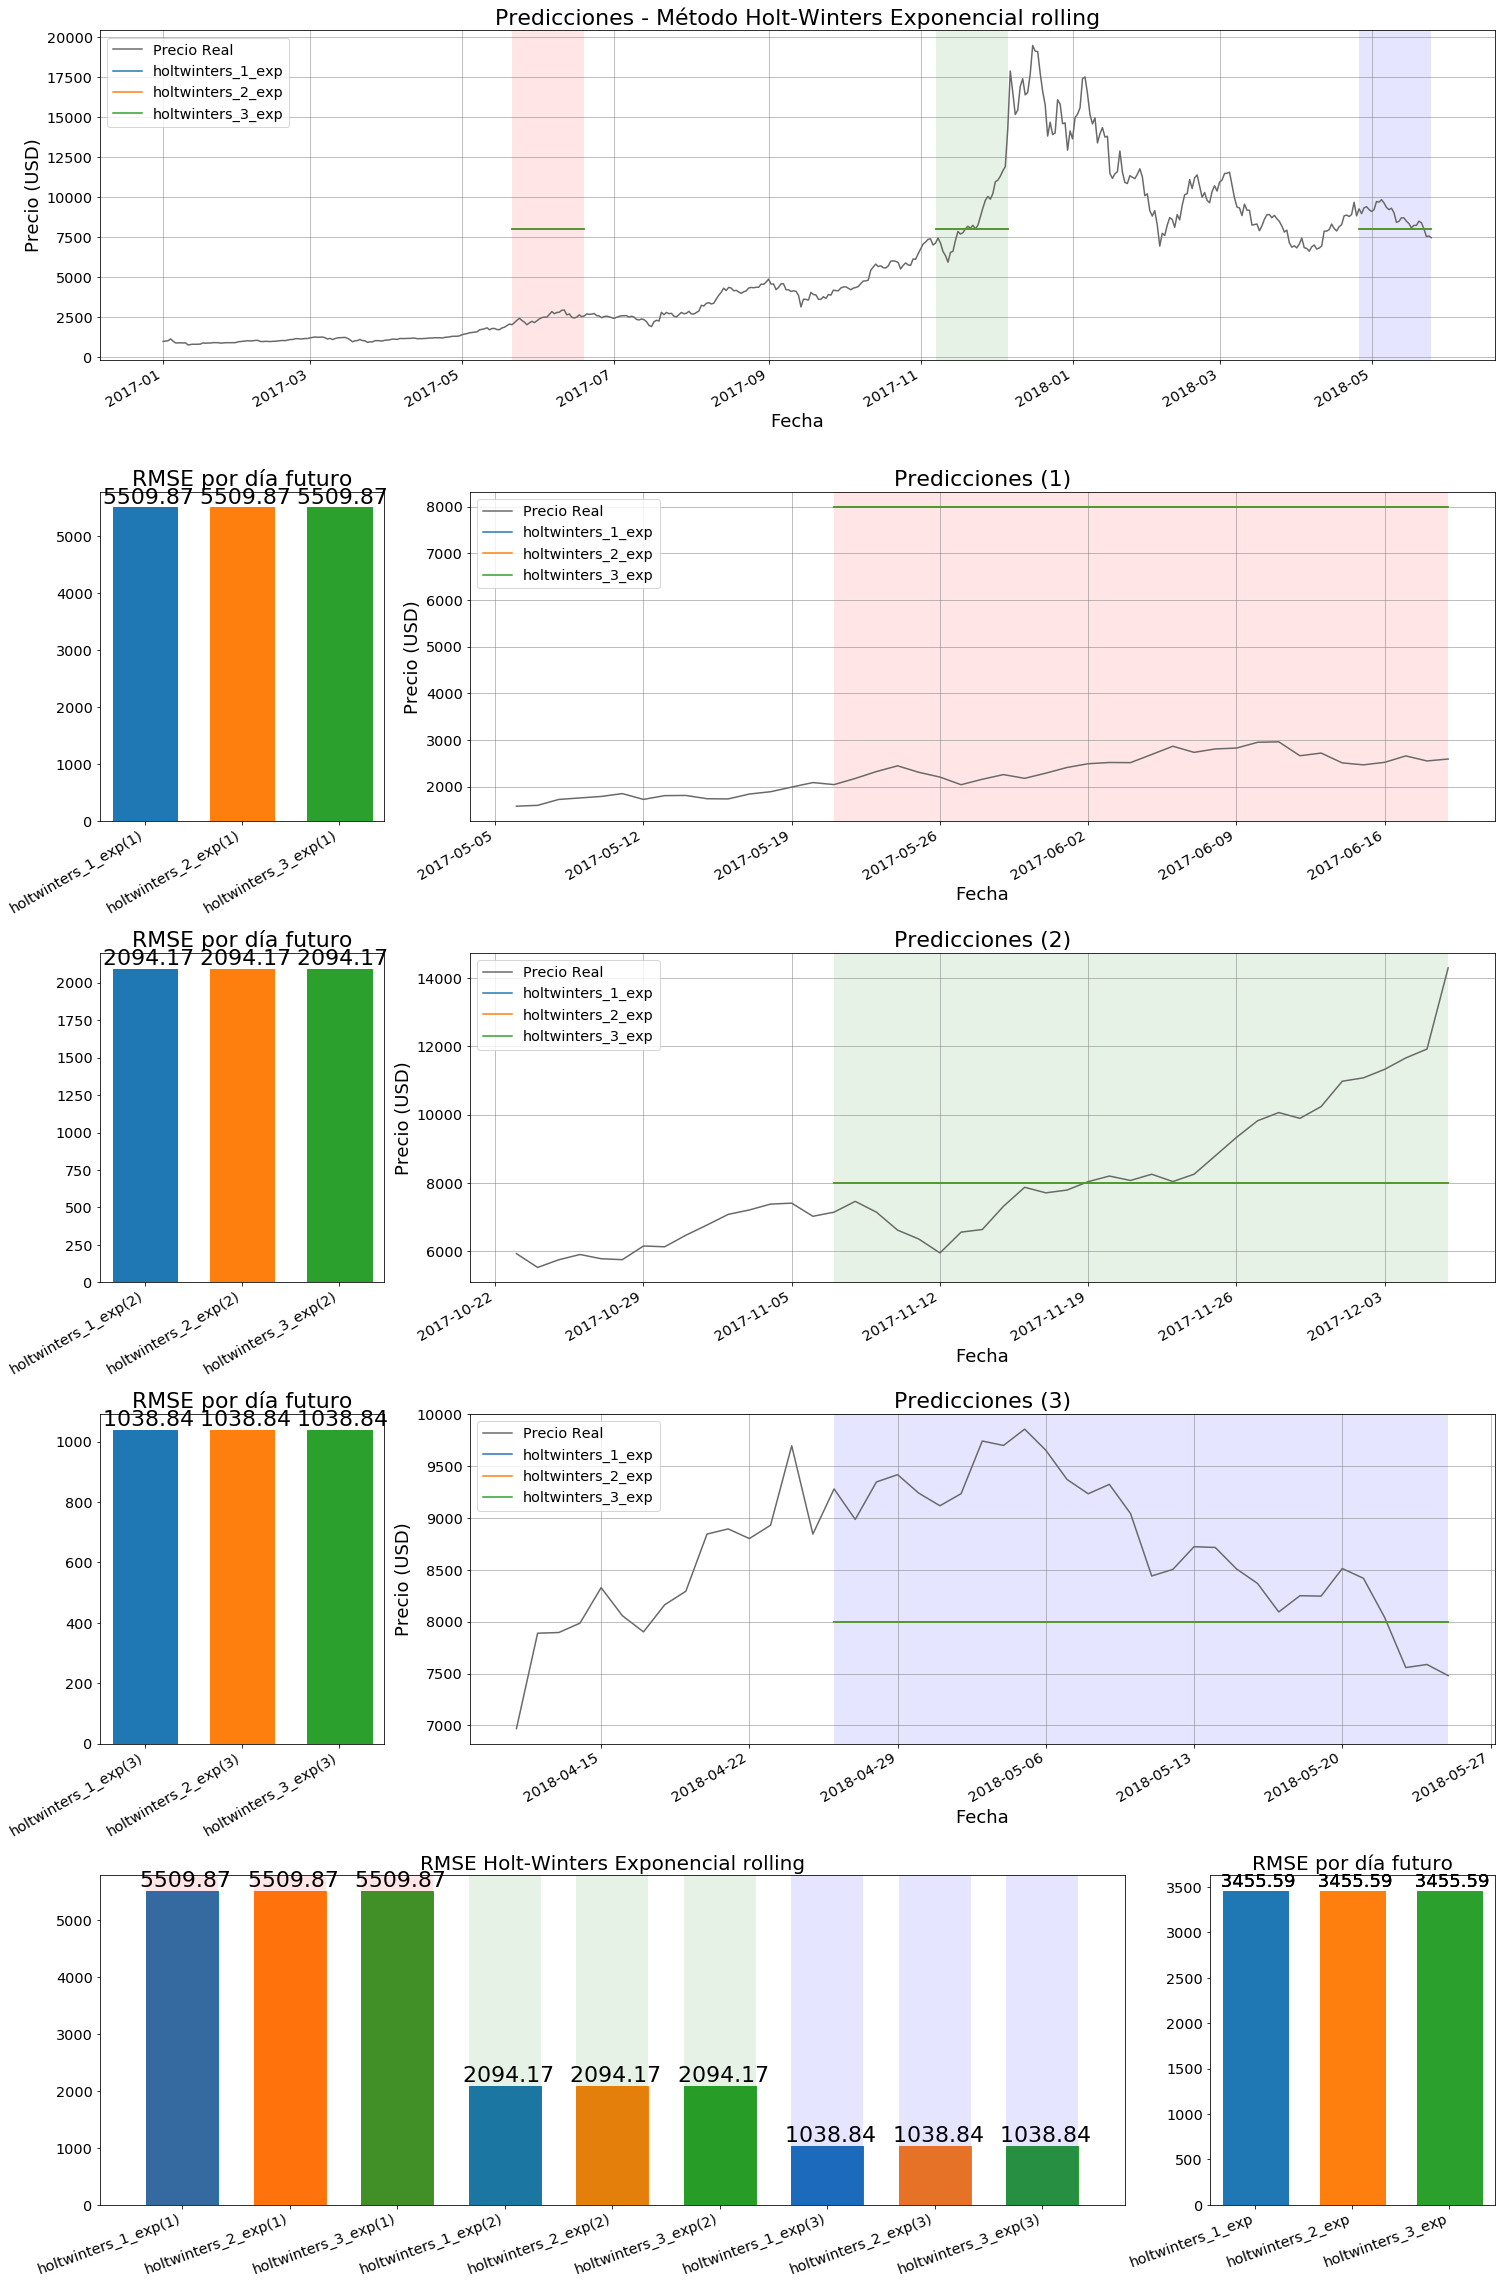

In [10]:
# Holt-Winters lineal (conjunto de entrenamiento móvil)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holtwinters_' + str(f) + '_lineal'] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]
            hw_lineal = ExponentialSmoothing(np.asarray(training), seasonal_periods=45, trend='add', seasonal='add').fit()
            test['holtwinters_' + str(f) + '_lineal'][i] = hw_lineal.forecast(1)
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_lineal_rolling.csv')

graficarBaselines(predicciones,"Holt-Winters Lineal rolling")

# Holt-Winters exponencial (conjunto de entrenamiento móvil)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['holtwinters_' + str(f) + '_exp'] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]
            holt_exp = ExponentialSmoothing(np.asarray(training), seasonal_periods=45, trend='mul', seasonal='mul').fit() 
            test['holtwinters_' + str(f) + '_exp'][i] = hw_lineal.forecast(1)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_exp_rolling.csv')

graficarBaselines(predicciones,"Holt-Winters Exponencial rolling")

Se eligió seasonal_periods=45 porque se puede notar que las tendencias se repiten más o menos cada 45 días. Se puede ver que este método mejora mucho el anterior. 
Aunque el RMSE sigue siendo más alto que el método naive, se puede ver que la curva de predicción del método Holt exponencial se aproxima mucho más a la curva real, y esto puede resultar mucho más significativo para predecir el movimiento del precio. 

Se probará el modelo ARIMA (Autoregressive Integrated Moving Average): intenta describir la correlación entre los datos y encontrar patrones para una predicción hacia el futuro. El método puede mejorarse utilizando estacionalidad: Seasonal ARIMA. 

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

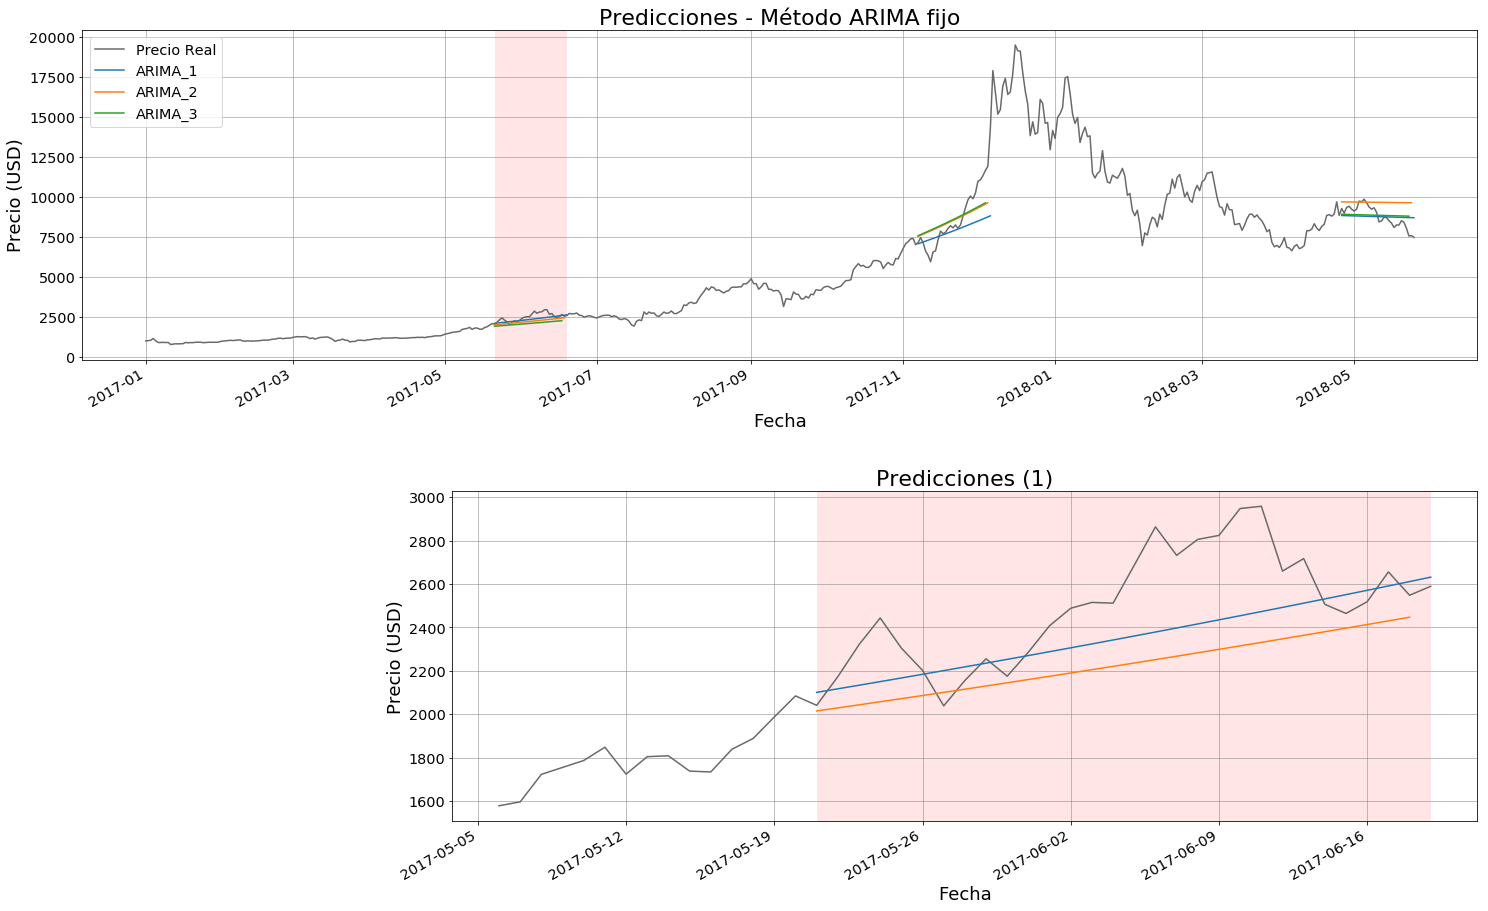

In [12]:
# ARIMA (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['ARIMA_' + str(f)] = np.nan
        training = dataset[0:-test_size-f+1]
        training.index = pd.DatetimeIndex(training.index.values,
                               freq=training.index.inferred_freq)
        arima = sm.tsa.statespace.SARIMAX(training, enforce_stationarity=False).fit() 
        test['ARIMA_' + str(f)] = arima.forecast(test_size)
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/ARIMA_fijo.csv')

graficarBaselines(predicciones,"ARIMA fijo")

In [ ]:
# ARIMA (conjunto de entrenamiento móvil)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for f in futuro:    
        test['ARIMA_' + str(f)] = np.nan
        for i in range(0,test_size):    
            training = dataset[0:-test_size+i-f+1]
            training.index = pd.DatetimeIndex(training.index.values,
                               freq=training.index.inferred_freq)
            arima = sm.tsa.statespace.SARIMAX(training, enforce_stationarity=False).fit() 
            test['ARIMA_' + str(f)][i] = arima.forecast(1)
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/ARIMA_rolling.csv')

graficarBaselines(predicciones,"ARIMA rolling")

Se concluye entonces que el método ARIMA es el que menor error consigue, mientras que el método Holt-Winters multiplicativo es el que mejor ajusta la curva de predicción a la curva real.

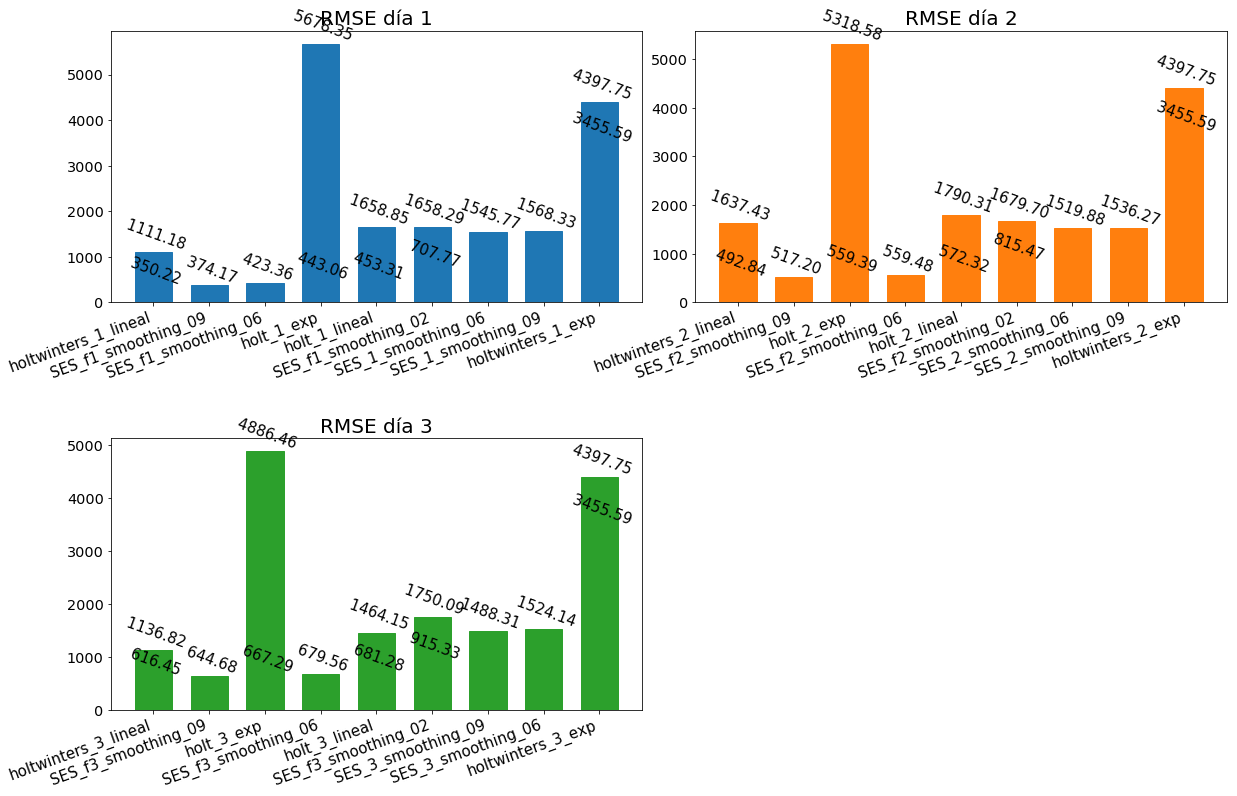

In [23]:
# Mostrar los mejores resultados para cada dia futuro
archivos = ['SES_02_fijo','SES_06_fijo','SES_09_fijo','Holt_lineal_fijo','Holt_exp_fijo','HoltWinters_lineal_fijo','HoltWinters_exp_fijo',
            'SES_02_rolling','SES_06_rolling','SES_09_rolling','Holt_lineal_rolling','Holt_exp_rolling','HoltWinters_lineal_rolling','HoltWinters_exp_rolling']
N_tests=3
todaspredicciones = data.copy()[['Close bitcoin']]
rmses = [[] for i in range(0,len(futuro))]
for archivo in archivos:
    prediccion = pd.read_csv('baselines/'+ archivo +'.csv')
    prediccion['Date'] = pd.to_datetime(prediccion['Date'])
    prediccion.set_index('Date', inplace=True)
    
    #Obtengo un dataframe con las predicciones de un método para todos los días y todos los subconjuntos de tests
    prediccion_solotests = pd.DataFrame()
    for n_test in range(0,N_tests): 
        end = int((n_test+1)*len(prediccion)/N_tests)
        subprediccion = prediccion[0:end]
        subprediccion_test = subprediccion[-test_size:]
        
        prediccion_solotests = prediccion_solotests.append(subprediccion_test)
    todaspredicciones = pd.merge(todaspredicciones,prediccion_solotests.drop(columns=['Close bitcoin']), how="left",left_index=True,right_index=True)
    
    # Calculo los RMSE para cada día (toma los tres subconjuntos de tests al mismo tiempo)
    for i in range(1,len(prediccion_solotests.columns)):
        rmse = sqrt(mean_squared_error(prediccion_solotests[prediccion_solotests.columns[0]], 
                                       prediccion_solotests[prediccion_solotests.columns[i]]))
        rmses[i-1].append([prediccion_solotests.columns[i],rmse])

def getKey(rmse):
    return rmse[1]

top_columns = ['Close bitcoin']

#Visualización de resultados
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.5)
for i in range(0,len(futuro)):
    top_rmses = sorted(rmses[i], key=getKey)
    rmses_x = [rmse[0] for rmse in top_rmses]
    rmses_y = [rmse[1] for rmse in top_rmses]

    top_columns.append(rmses_x[0])
    
    width = 1/1.5
    barplot = plt.subplot(gs[i])
    bars = plt.bar(rmses_x, rmses_y, width)
    for rect in bars: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=15, ha='center',va='bottom',rotation=-20)
            rect.set_color(colores_futuro[i])
    plt.xticks(rotation=20, ha='right', fontsize=15)
    plt.title("RMSE día "+ str(futuro[i]),fontsize=20)
    plt.savefig("baselines/rmses.png", bbox_inches='tight')

#graficarBaselines(todaspredicciones.filter(top_columns),"Top")